In [1]:
import pickle
import yaml

import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from math import floor
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import spearmanr
from decimal import Decimal

from carot.utils import get_source_target_transport, score_transports_and_targets_combinations
from cmonge.utils import load_config
from carot.trainers.conditional_monge_trainer import ConditionalMongeTrainer
from carot.datasets.conditional_loader import ConditionalDataModule

In [2]:
default_colors = {
    "indigo": "#332288",
    "cyan": "#88CCEE",
    "teal": "#44AA99",
    "green": "#117733",
    "olive": "#999933",
    "sand": "#DDCC77",
    "rose": "#CC6677",
    "wine": "#882255",
    "purple": "#AA4499",
    "grey": "#DDDDDD",
}

ot_colors = {
    "blue": "#648FFF",
    "purple": "#785EF0",
    "pink": "#DC267F",
    "orange": "#FE6100",
    "yellow": "#FFB000",
    "grey": "#DDDDDD",
}

eval_setting_map = {
    "identity": default_colors["wine"],
    "CAROT": default_colors["cyan"],
    "conCAROT": default_colors["indigo"],
    "within condition": default_colors["green"],
}

geneset_map = {
    "functional": default_colors["olive"],
    "functional+score": default_colors["rose"],
    "HVG": default_colors["teal"],
    "random": default_colors["sand"],
}

subset_map = {
    "CD4": default_colors["teal"],
    "CD8": default_colors["purple"],
}

ot_map = {
    "source": ot_colors["blue"],
    "target": ot_colors["pink"],
    "transport": ot_colors["yellow"],
    "rest": ot_colors["grey"]
}


In [3]:
sns.set(font="Arial")
sns.set_context("paper")
sns.set_style("whitegrid")
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['ytick.left'] = True
mpl.rcParams['xtick.bottom'] = True

In [4]:
with open("/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/CD8_sel_cars.txt") as f:
    CD8_sel_cars = f.readlines()
with open("/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/CD4_sel_cars.txt") as f:
    CD4_sel_cars = f.readlines()
CD8_sel_cars = [c[:-1] for c in CD8_sel_cars]
CD4_sel_cars = [c[:-1] for c in CD4_sel_cars]

sel_cars = {"CD8": CD8_sel_cars, "CD4": CD4_sel_cars}

In [5]:
features = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/functional_and_score_genes.txt"

logger_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/logger.json"
base_config_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/cmonge/sel_CARs_LN_True_grad_acc_4_cosine/"
base_ckpt_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/cmonge/sel_CARs_LN_True_grad_acc_4_cosine/"
base_fig_save = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Figures/cmonge/Score_dist_comparison/sel_CARs"

In [6]:
expr_list = []
meta_list = []
for subset in ["CD4", "CD8"]:
    adata = sc.read_h5ad(f"/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}.h5ad")
    config_path = f"{base_config_path}{subset}_esm_XL_tail_dim_FuncScore/config.yaml"
    config = load_config(config_path)
    config.model.checkpointing_path = f"{base_ckpt_path}{subset}_esm_XL_tail_dim_FuncScore/model"
    config.data.file_path = f"/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}.h5ad"
    config.data.features = features
    config.data.drugs_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/CAR_variants.txt"
    config.model.embedding.model_dir = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/embedding/"

    for car in adata.obs["CAR_Variant"].unique():
        if car in ["NA-NA-NA", "NA-NA-z"]:
            continue
        print(car)
        batch_size = min(sum(adata.obs["CAR_Variant"]==car), sum(adata.obs["CAR_Variant"]=="NA-NA-NA"))
        batch_size = floor(batch_size * config.data.split[1])
        config.data.batch_size=batch_size
        config.condition.conditions = [car]
        config.model.embedding.model_dir = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/embedding/"

        datamodule = ConditionalDataModule(config.data, config.condition, config.ae)
        trainer = ConditionalMongeTrainer.load_checkpoint(
            jobid=1,
            logger_path=logger_path, 
            config=config.model, 
            datamodule=datamodule, 
            ckpt_path=config.model.checkpointing_path
            )
    
        all_expr, all_meta = get_source_target_transport(datamodule=datamodule, 
                                                         trainer=trainer,
                                                         conditions=[car])
        expr_list.append(all_expr)
        meta_list.append(all_meta)

41BB-41BB-z


2025-10-10 11:26:32.020 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-41BB-z
2025-10-10 11:26:32.299 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:26:32.425 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (746,), valid: (187,), test: (0,).
2025-10-10 11:26:32.426 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-10-10 11:26:32.426 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:26:32.426 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:26:33.432 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
41BB-CD28-z


2025-10-10 11:26:34.466 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD28-z
2025-10-10 11:26:34.736 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:26:34.741 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1085,), valid: (272,), test: (0,).
2025-10-10 11:26:34.741 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-10-10 11:26:34.742 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:26:34.742 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:26:34.770 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
41BB-CD40-z


2025-10-10 11:26:35.262 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD40-z
2025-10-10 11:26:35.614 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:26:35.620 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (776,), valid: (195,), test: (0,).
2025-10-10 11:26:35.620 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-10-10 11:26:35.620 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:26:35.621 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:26:35.645 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
41BB-CTLA4-z


2025-10-10 11:26:36.046 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CTLA4-z
2025-10-10 11:26:36.234 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:26:36.239 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (248,), valid: (63,), test: (0,).
2025-10-10 11:26:36.239 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-10-10 11:26:36.240 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:26:36.240 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:26:36.261 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(62, 5120)
41BB-IL15RA-z


2025-10-10 11:26:37.132 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-IL15RA-z
2025-10-10 11:26:37.376 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:26:37.382 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (840,), valid: (211,), test: (0,).
2025-10-10 11:26:37.382 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-10-10 11:26:37.382 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:26:37.382 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:26:37.406 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
41BB-NA-z


2025-10-10 11:26:37.875 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-NA-z
2025-10-10 11:26:38.165 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:26:38.172 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (765,), valid: (192,), test: (0,).
2025-10-10 11:26:38.172 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-10-10 11:26:38.172 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:26:38.172 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:26:38.195 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
CD28-41BB-z


2025-10-10 11:26:38.625 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-41BB-z
2025-10-10 11:26:38.902 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:26:38.907 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (172,), valid: (43,), test: (0,).
2025-10-10 11:26:38.908 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-10-10 11:26:38.908 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:26:38.908 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:26:38.929 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(43, 5120)
CD28-CD28-z


2025-10-10 11:26:40.032 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD28-z
2025-10-10 11:26:40.481 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:26:40.489 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (833,), valid: (209,), test: (0,).
2025-10-10 11:26:40.489 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-10-10 11:26:40.490 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:26:40.490 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:26:40.522 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
CD28-CD40-z


2025-10-10 11:26:40.960 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD40-z
2025-10-10 11:26:41.446 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:26:41.452 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (818,), valid: (205,), test: (0,).
2025-10-10 11:26:41.452 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-10-10 11:26:41.452 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:26:41.453 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:26:41.474 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
CD28-CTLA4-z


2025-10-10 11:26:41.926 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CTLA4-z
2025-10-10 11:26:42.387 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:26:42.394 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (214,), valid: (54,), test: (0,).
2025-10-10 11:26:42.394 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-10-10 11:26:42.394 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:26:42.394 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:26:42.420 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(53, 5120)
CD28-IL15RA-z


2025-10-10 11:26:43.441 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-IL15RA-z
2025-10-10 11:26:43.983 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:26:43.989 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1153,), valid: (289,), test: (0,).
2025-10-10 11:26:43.990 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-10-10 11:26:43.990 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:26:43.990 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:26:44.021 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
CD28-NA-z


2025-10-10 11:26:44.476 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-NA-z
2025-10-10 11:26:44.996 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:26:45.003 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1145,), valid: (287,), test: (0,).
2025-10-10 11:26:45.003 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-10-10 11:26:45.003 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:26:45.003 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:26:45.025 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
CD40-41BB-z


2025-10-10 11:26:45.446 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-41BB-z
2025-10-10 11:26:45.978 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:26:45.985 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (556,), valid: (140,), test: (0,).
2025-10-10 11:26:45.985 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-10-10 11:26:45.985 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:26:45.985 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:26:46.009 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(139, 5120)
CD40-CD28-z


2025-10-10 11:26:47.021 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD28-z
2025-10-10 11:26:47.530 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:26:47.536 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (590,), valid: (148,), test: (0,).
2025-10-10 11:26:47.536 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-10-10 11:26:47.537 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:26:47.537 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:26:47.559 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(147, 5120)
CD40-CD40-z


2025-10-10 11:26:48.569 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD40-z
2025-10-10 11:26:49.082 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:26:49.088 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (542,), valid: (136,), test: (0,).
2025-10-10 11:26:49.088 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-10-10 11:26:49.089 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:26:49.089 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:26:49.112 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(135, 5120)
CD40-CTLA4-z


2025-10-10 11:26:50.154 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CTLA4-z
2025-10-10 11:26:50.725 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:26:50.732 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (259,), valid: (65,), test: (0,).
2025-10-10 11:26:50.732 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-10-10 11:26:50.732 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:26:50.732 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:26:50.758 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(64, 5120)
CD40-IL15RA-z


2025-10-10 11:26:51.791 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-IL15RA-z
2025-10-10 11:26:52.299 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:26:52.305 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (645,), valid: (162,), test: (0,).
2025-10-10 11:26:52.306 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-10-10 11:26:52.306 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:26:52.306 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:26:52.330 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
CD40-NA-z


2025-10-10 11:26:52.753 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-NA-z
2025-10-10 11:26:53.267 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:26:53.273 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (794,), valid: (199,), test: (0,).
2025-10-10 11:26:53.273 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-10-10 11:26:53.273 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:26:53.273 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:26:53.296 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
CTLA4-41BB-z


2025-10-10 11:26:53.726 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-41BB-z
2025-10-10 11:26:54.244 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:26:54.249 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (188,), valid: (48,), test: (0,).
2025-10-10 11:26:54.250 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-10-10 11:26:54.250 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:26:54.250 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:26:54.279 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(47, 5120)
CTLA4-CD28-z


2025-10-10 11:26:55.288 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD28-z
2025-10-10 11:26:55.816 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:26:55.822 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (452,), valid: (113,), test: (0,).
2025-10-10 11:26:55.822 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-10-10 11:26:55.823 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:26:55.823 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:26:55.848 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(113, 5120)
CTLA4-CD40-z


2025-10-10 11:26:56.935 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD40-z
2025-10-10 11:26:57.401 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:26:57.406 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (162,), valid: (41,), test: (0,).
2025-10-10 11:26:57.406 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-10-10 11:26:57.407 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:26:57.407 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:26:57.430 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(40, 5120)
CTLA4-CTLA4-z


2025-10-10 11:26:59.791 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CTLA4-z
2025-10-10 11:27:00.016 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:00.021 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (222,), valid: (56,), test: (0,).
2025-10-10 11:27:00.021 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-10-10 11:27:00.022 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:00.022 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:00.045 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(55, 5120)
CTLA4-IL15RA-z


2025-10-10 11:27:00.913 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-IL15RA-z
2025-10-10 11:27:01.139 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:01.144 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (152,), valid: (38,), test: (0,).
2025-10-10 11:27:01.145 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-10-10 11:27:01.145 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:01.145 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:01.169 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(38, 5120)
CTLA4-NA-z


2025-10-10 11:27:02.010 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-NA-z
2025-10-10 11:27:02.222 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:02.227 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (171,), valid: (43,), test: (0,).
2025-10-10 11:27:02.227 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-10-10 11:27:02.227 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:02.227 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:02.250 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(42, 5120)
IL15RA-41BB-z


2025-10-10 11:27:03.076 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-41BB-z
2025-10-10 11:27:03.288 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:03.293 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (894,), valid: (224,), test: (0,).
2025-10-10 11:27:03.293 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-10-10 11:27:03.293 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:03.294 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:03.316 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
IL15RA-CD28-z


2025-10-10 11:27:03.579 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD28-z
2025-10-10 11:27:03.793 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:03.798 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (991,), valid: (248,), test: (0,).
2025-10-10 11:27:03.798 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-10-10 11:27:03.798 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:03.798 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:03.821 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
IL15RA-CD40-z


2025-10-10 11:27:04.075 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD40-z
2025-10-10 11:27:04.288 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:04.294 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (790,), valid: (198,), test: (0,).
2025-10-10 11:27:04.294 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-10-10 11:27:04.294 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:04.295 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:04.316 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
IL15RA-CTLA4-z


2025-10-10 11:27:04.694 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CTLA4-z
2025-10-10 11:27:04.998 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:05.003 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (364,), valid: (92,), test: (0,).
2025-10-10 11:27:05.004 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-10-10 11:27:05.004 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:05.004 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:05.027 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(91, 5120)
IL15RA-IL15RA-z


2025-10-10 11:27:06.034 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-IL15RA-z
2025-10-10 11:27:06.306 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:06.311 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1110,), valid: (278,), test: (0,).
2025-10-10 11:27:06.311 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-10-10 11:27:06.312 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:06.312 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:06.333 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
IL15RA-NA-z


2025-10-10 11:27:06.788 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-NA-z
2025-10-10 11:27:07.060 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:07.066 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1123,), valid: (281,), test: (0,).
2025-10-10 11:27:07.066 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-10-10 11:27:07.066 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:07.066 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:07.088 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
41BB-41BB-z


2025-10-10 11:27:08.444 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-41BB-z
2025-10-10 11:27:08.756 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:08.764 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2025-10-10 11:27:08.764 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-10-10 11:27:08.765 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:08.765 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:08.799 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(157, 5120)
41BB-CD28-z


2025-10-10 11:27:09.796 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD28-z
2025-10-10 11:27:10.098 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:10.104 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (581,), valid: (146,), test: (0,).
2025-10-10 11:27:10.104 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-10-10 11:27:10.104 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:10.104 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:10.127 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(145, 5120)
41BB-CD40-z


2025-10-10 11:27:11.123 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD40-z
2025-10-10 11:27:11.522 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:11.529 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (377,), valid: (95,), test: (0,).
2025-10-10 11:27:11.529 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-10-10 11:27:11.530 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:11.530 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:11.557 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(94, 5120)
41BB-CTLA4-z


2025-10-10 11:27:12.536 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CTLA4-z
2025-10-10 11:27:12.981 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:12.986 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (212,), valid: (53,), test: (0,).
2025-10-10 11:27:12.987 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-10-10 11:27:12.987 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:12.987 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:13.015 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(53, 5120)
41BB-IL15RA-z


2025-10-10 11:27:13.410 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-IL15RA-z
2025-10-10 11:27:13.872 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:13.880 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (844,), valid: (212,), test: (0,).
2025-10-10 11:27:13.880 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-10-10 11:27:13.880 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:13.881 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:13.907 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(211, 5120)
41BB-NA-z


2025-10-10 11:27:14.785 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-NA-z
2025-10-10 11:27:14.984 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:14.990 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (789,), valid: (198,), test: (0,).
2025-10-10 11:27:14.991 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-10-10 11:27:14.991 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:14.991 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:15.014 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(197, 5120)
CD28-41BB-z


2025-10-10 11:27:16.041 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-41BB-z
2025-10-10 11:27:16.431 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:16.438 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (206,), valid: (52,), test: (0,).
2025-10-10 11:27:16.438 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-10-10 11:27:16.439 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:16.439 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:16.464 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(51, 5120)
CD28-CD28-z


2025-10-10 11:27:17.474 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD28-z
2025-10-10 11:27:17.885 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:17.892 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (672,), valid: (168,), test: (0,).
2025-10-10 11:27:17.892 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-10-10 11:27:17.892 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:17.892 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:17.920 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(168, 5120)
CD28-CD40-z


2025-10-10 11:27:18.936 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD40-z
2025-10-10 11:27:19.335 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:19.342 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (526,), valid: (132,), test: (0,).
2025-10-10 11:27:19.342 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-10-10 11:27:19.342 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:19.343 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:19.367 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(131, 5120)
CD28-CTLA4-z


2025-10-10 11:27:21.103 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CTLA4-z
2025-10-10 11:27:21.310 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:21.316 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (350,), valid: (88,), test: (0,).
2025-10-10 11:27:21.316 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-10-10 11:27:21.316 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:21.316 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:21.345 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(87, 5120)
CD28-IL15RA-z


2025-10-10 11:27:22.187 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-IL15RA-z
2025-10-10 11:27:22.382 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:22.388 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (719,), valid: (180,), test: (0,).
2025-10-10 11:27:22.388 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-10-10 11:27:22.388 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:22.388 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:22.411 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(179, 5120)
CD28-NA-z


2025-10-10 11:27:23.235 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-NA-z
2025-10-10 11:27:23.440 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:23.446 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (883,), valid: (221,), test: (0,).
2025-10-10 11:27:23.446 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-10-10 11:27:23.446 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:23.446 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:23.468 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(220, 5120)
CD40-41BB-z


2025-10-10 11:27:24.289 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-41BB-z
2025-10-10 11:27:24.484 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:24.489 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (487,), valid: (122,), test: (0,).
2025-10-10 11:27:24.490 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-10-10 11:27:24.490 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:24.490 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:24.512 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(121, 5120)
CD40-CD28-z


2025-10-10 11:27:25.337 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD28-z
2025-10-10 11:27:25.532 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:25.537 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (774,), valid: (194,), test: (0,).
2025-10-10 11:27:25.538 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-10-10 11:27:25.538 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:25.538 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:25.561 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(193, 5120)
CD40-CD40-z


2025-10-10 11:27:26.396 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD40-z
2025-10-10 11:27:26.611 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:26.616 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1089,), valid: (273,), test: (0,).
2025-10-10 11:27:26.617 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-10-10 11:27:26.617 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:26.617 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:26.639 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(272, 5120)
CD40-CTLA4-z


2025-10-10 11:27:27.477 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CTLA4-z
2025-10-10 11:27:27.682 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:27.687 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (559,), valid: (140,), test: (0,).
2025-10-10 11:27:27.687 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-10-10 11:27:27.688 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:27.688 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:27.710 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(139, 5120)
CD40-IL15RA-z


2025-10-10 11:27:28.176 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-IL15RA-z
2025-10-10 11:27:28.451 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:28.456 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (552,), valid: (139,), test: (0,).
2025-10-10 11:27:28.456 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-10-10 11:27:28.456 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:28.457 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:28.479 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(138, 5120)
CD40-NA-z


2025-10-10 11:27:29.409 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-NA-z
2025-10-10 11:27:29.648 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:29.654 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1004,), valid: (251,), test: (0,).
2025-10-10 11:27:29.654 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-10-10 11:27:29.654 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:29.654 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:29.676 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(251, 5120)
CTLA4-41BB-z


2025-10-10 11:27:30.663 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-41BB-z
2025-10-10 11:27:30.914 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:30.920 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (137,), valid: (35,), test: (0,).
2025-10-10 11:27:30.920 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-10-10 11:27:30.921 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:30.921 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:30.946 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(34, 5120)
CTLA4-CD28-z


2025-10-10 11:27:31.989 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD28-z
2025-10-10 11:27:32.249 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:32.257 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (202,), valid: (51,), test: (0,).
2025-10-10 11:27:32.257 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-10-10 11:27:32.257 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:32.258 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:32.282 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(50, 5120)
CTLA4-CD40-z


2025-10-10 11:27:33.384 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD40-z
2025-10-10 11:27:33.716 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:33.721 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (220,), valid: (56,), test: (0,).
2025-10-10 11:27:33.721 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-10-10 11:27:33.722 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:33.722 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:33.744 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(55, 5120)
CTLA4-CTLA4-z


2025-10-10 11:27:34.172 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CTLA4-z
2025-10-10 11:27:34.489 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:34.495 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (97,), valid: (25,), test: (0,).
2025-10-10 11:27:34.496 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-10-10 11:27:34.496 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:34.496 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:34.521 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(24, 5120)
CTLA4-IL15RA-z


2025-10-10 11:27:35.569 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-IL15RA-z
2025-10-10 11:27:35.983 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:35.990 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (187,), valid: (47,), test: (0,).
2025-10-10 11:27:35.990 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-10-10 11:27:35.990 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:35.993 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:36.030 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(46, 5120)
CTLA4-NA-z


2025-10-10 11:27:37.026 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-NA-z
2025-10-10 11:27:37.399 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:37.405 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (201,), valid: (51,), test: (0,).
2025-10-10 11:27:37.405 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-10-10 11:27:37.406 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:37.406 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:37.429 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(50, 5120)
IL15RA-41BB-z


2025-10-10 11:27:37.809 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-41BB-z
2025-10-10 11:27:38.216 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:38.224 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (964,), valid: (242,), test: (0,).
2025-10-10 11:27:38.224 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-10-10 11:27:38.225 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:38.226 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:38.258 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(241, 5120)
IL15RA-CD28-z


2025-10-10 11:27:39.242 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD28-z
2025-10-10 11:27:39.623 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:39.629 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2025-10-10 11:27:39.629 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-10-10 11:27:39.629 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:39.630 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:39.653 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(157, 5120)
IL15RA-CD40-z


2025-10-10 11:27:40.043 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD40-z
2025-10-10 11:27:40.429 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:40.435 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1258,), valid: (315,), test: (0,).
2025-10-10 11:27:40.435 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-10-10 11:27:40.436 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:40.436 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:40.457 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(284, 5120)
IL15RA-CTLA4-z


2025-10-10 11:27:41.476 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CTLA4-z
2025-10-10 11:27:41.855 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:41.862 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (936,), valid: (234,), test: (0,).
2025-10-10 11:27:41.863 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-10-10 11:27:41.863 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:41.864 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:42.775 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(234, 5120)
IL15RA-IL15RA-z


2025-10-10 11:27:43.621 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-IL15RA-z
2025-10-10 11:27:43.821 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:43.826 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (489,), valid: (123,), test: (0,).
2025-10-10 11:27:43.827 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-10-10 11:27:43.827 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:43.827 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:43.850 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(122, 5120)
IL15RA-NA-z


2025-10-10 11:27:44.675 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-NA-z
2025-10-10 11:27:44.872 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-10-10 11:27:44.877 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (925,), valid: (232,), test: (0,).
2025-10-10 11:27:44.878 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-10-10 11:27:44.878 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-10-10 11:27:44.878 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-10-10 11:27:44.899 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(231, 5120)


In [7]:
expr = pd.concat(expr_list)
meta = pd.concat(meta_list)
expr.index = expr.index.astype(str)
meta.index = meta.index.astype(str)

In [8]:
adata = sc.AnnData(expr)
adata.obs = meta
adata.obs_names_make_unique()
adata.obs["ident"]=adata.obs["ident"].astype(str)
adata.obs.loc[adata.obs['ident']=="CD4_Disfunctional", "ident"] = "CD4_Dysfunctional"
adata.obs.loc[adata.obs['ident']=="CD4_Early_Disfuncional", "ident"] = "CD4_Early_Dysfunctional"

/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [9]:
for i in adata.obs["ident"].unique():
    print(i)

CD4_Early_Activated
CD4_Activated_Memory
CD4_Activated
CD4_Dysfunctional
CD4_Resting Memory
CD4_T-reg_like
CD4_Early_Dysfunctional
Terminal
CD8_Early_Cytotoxic
CD8_Cycling_Effector
CD8_Late_Bystander
CD4_Cycling
CD8_Activated
CD8_Cycling
CD8_Resting_Memory
CD8_Late_Cytotoxic


# Geneset scores

In [17]:
genesets = {
"Cytotoxicity": ["GZMB", "PRF1", "TNFRSF9"], 
"Proinflammatory": ["IFNG", "TNF", "CRTAM", "CSF2", "XCL1", "XCL2", "CCL1", "CCL4"],
"Memory": ["TCF", "SELL", "CCR7", "LEF1", "IL7R"],
"CD4_Th1": ["IL2", "IFNG", "TNF"],	
"CD4_Th2": ["IL5", "IL13", "IL4"]
    }

In [18]:
sc.tl.score_genes(adata, genesets["Cytotoxicity"], score_name="Cytotoxicity_OT")
sc.tl.score_genes(adata, genesets["Proinflammatory"], score_name="Proinflammatory_OT")
sc.tl.score_genes(adata, genesets["Memory"], score_name="Memory_OT")

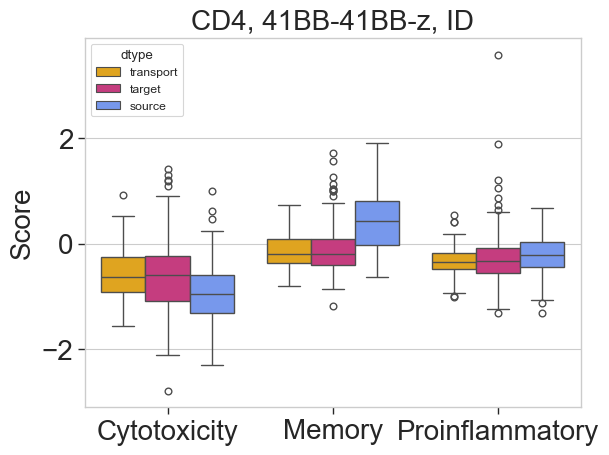

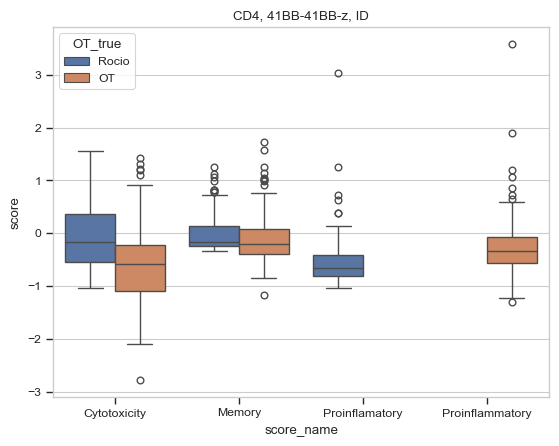

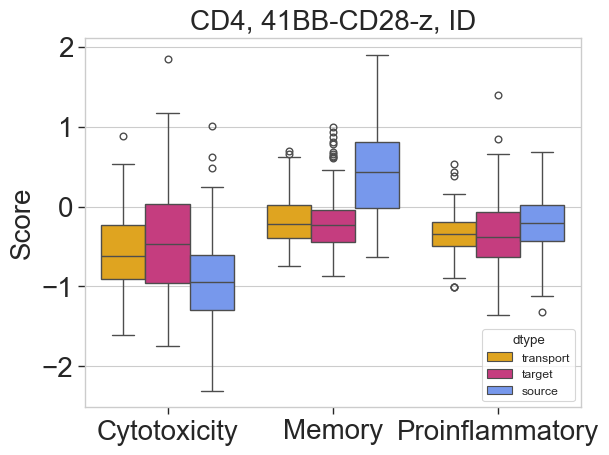

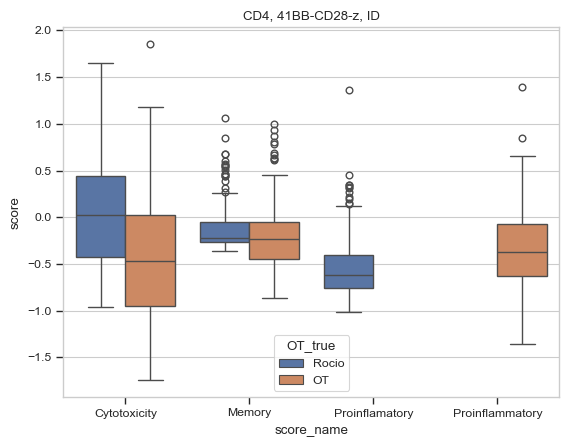

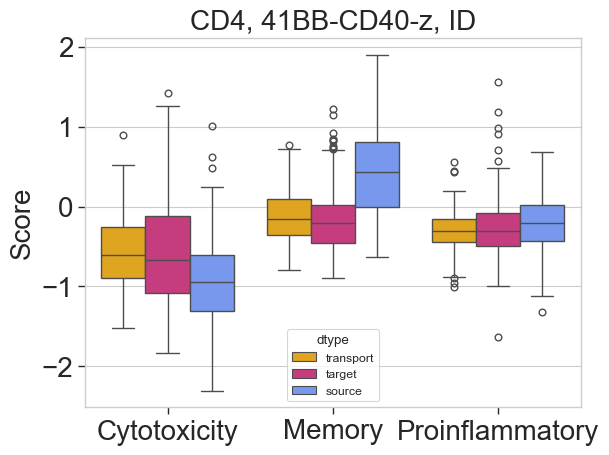

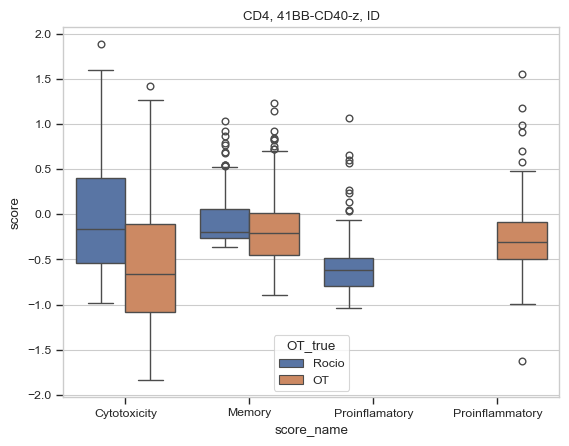

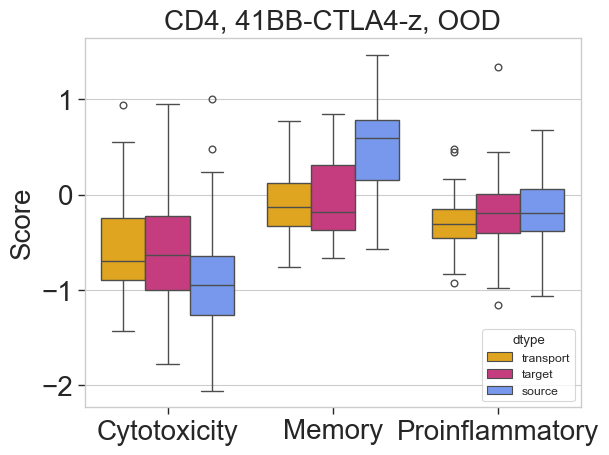

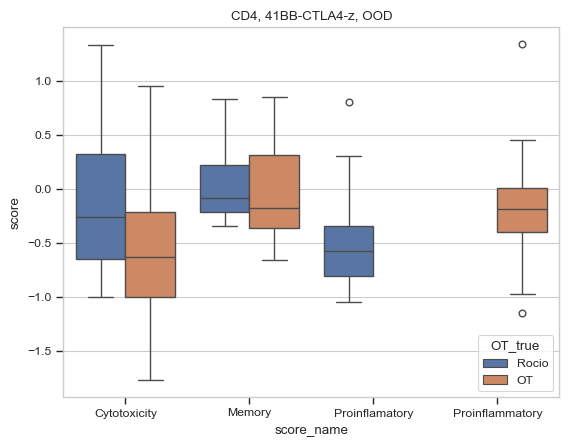

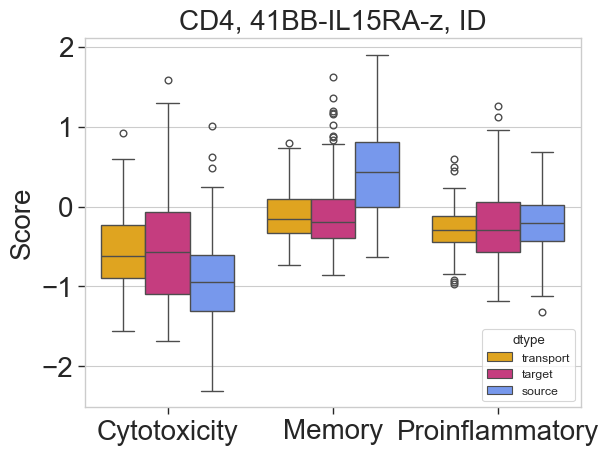

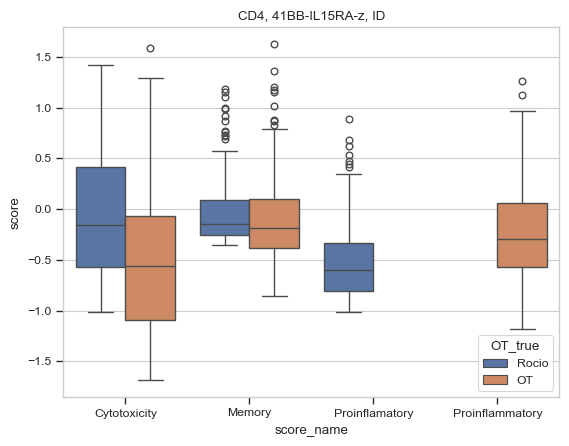

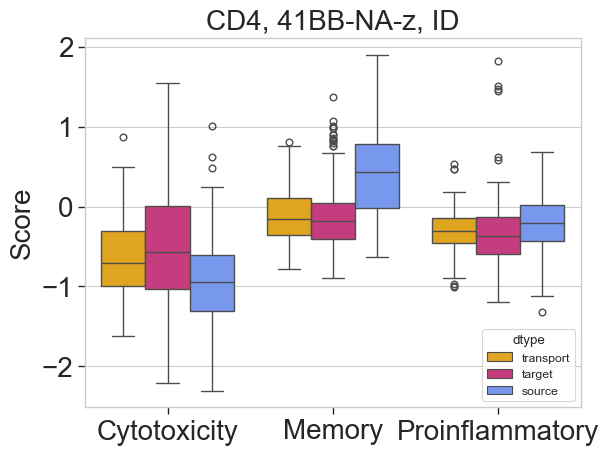

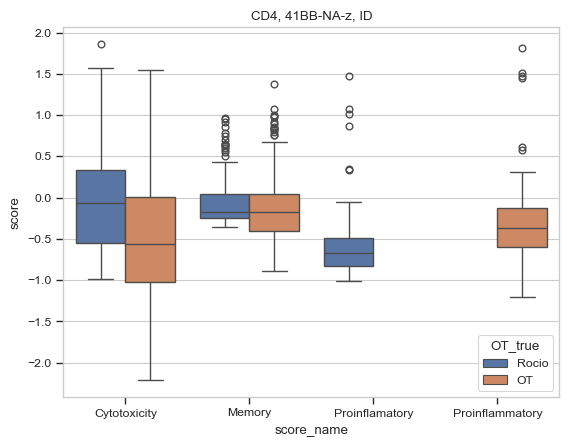

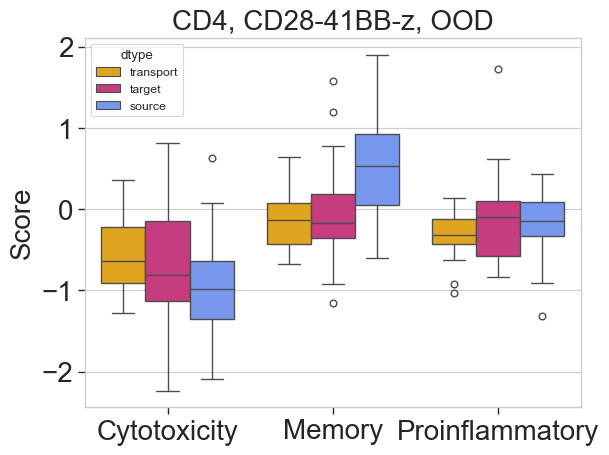

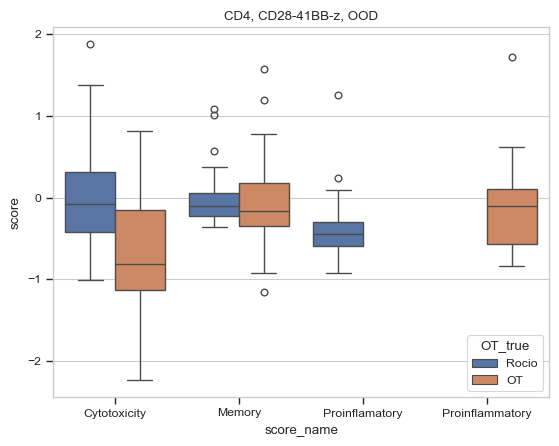

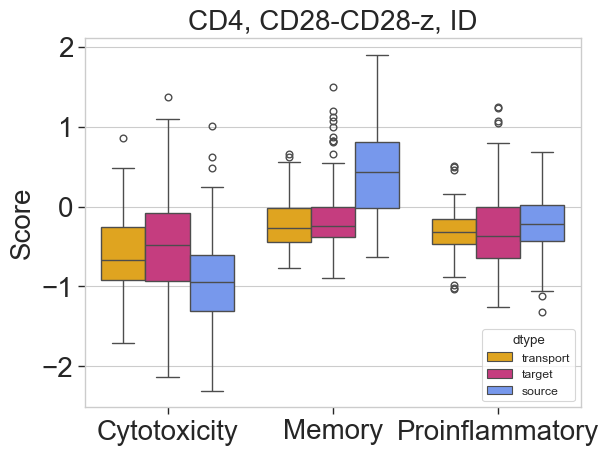

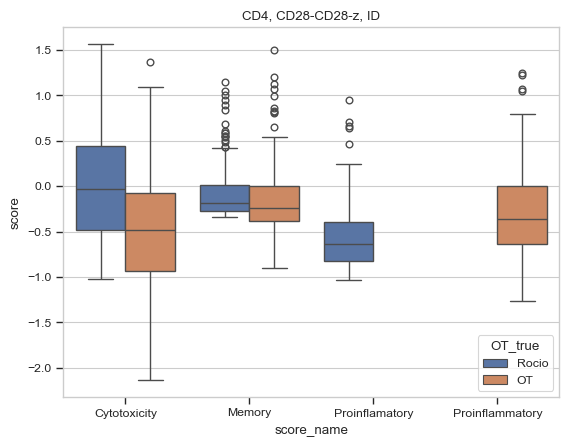

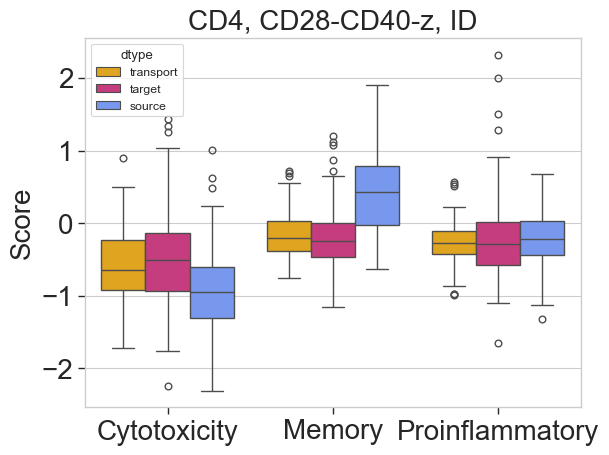

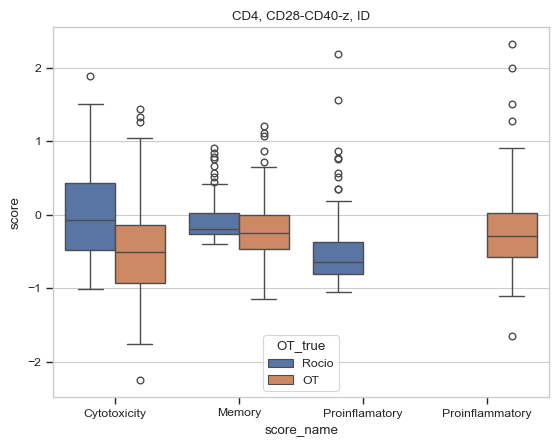

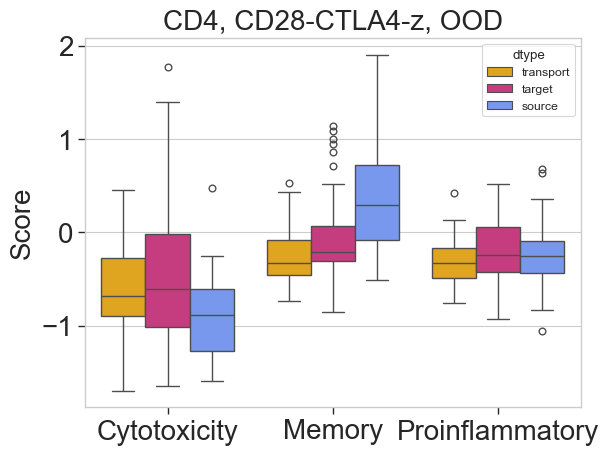

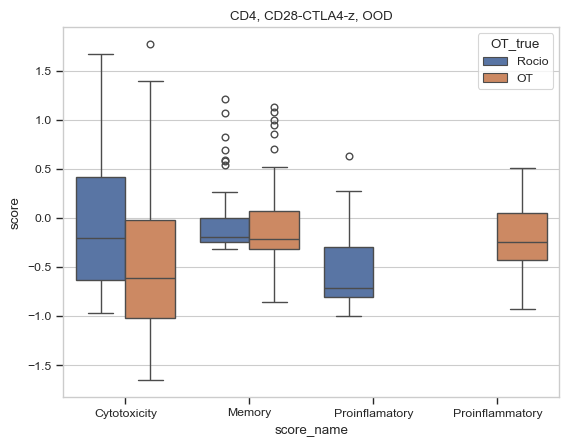

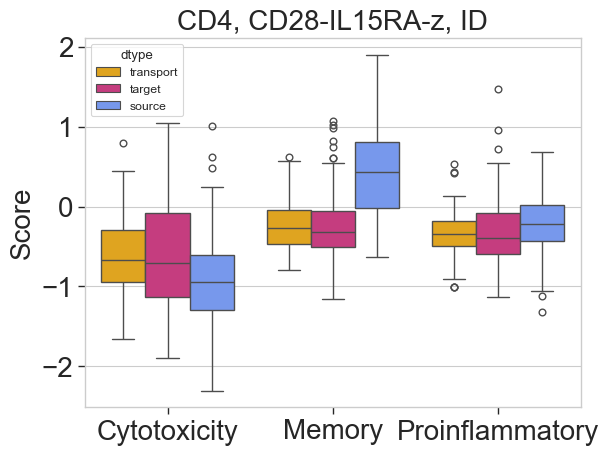

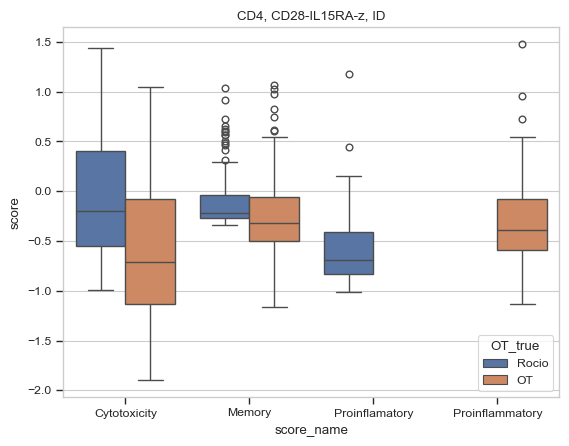

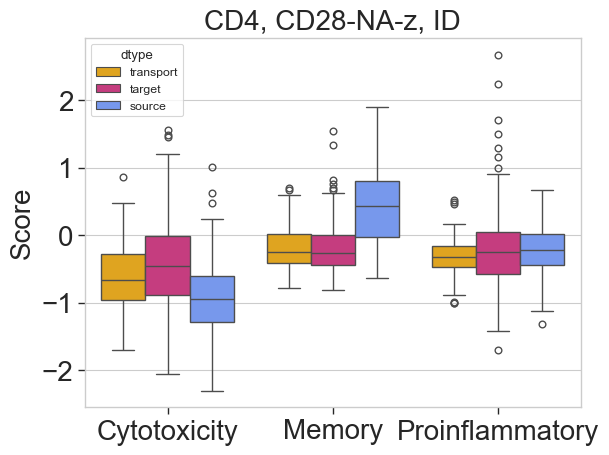

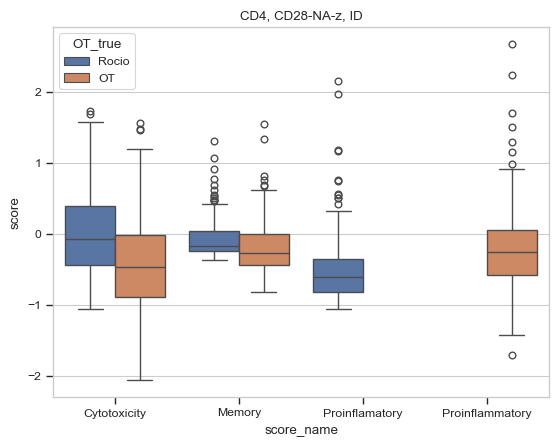

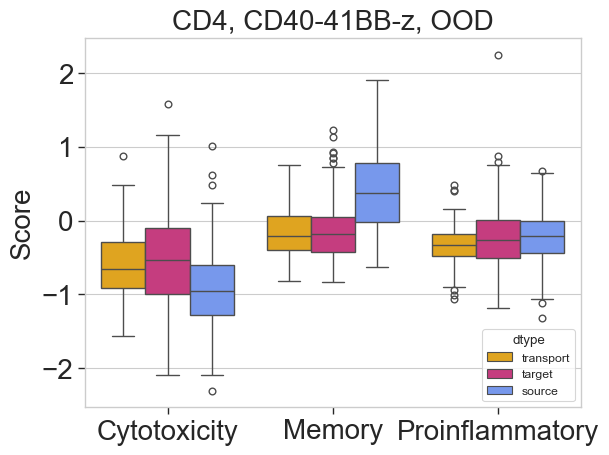

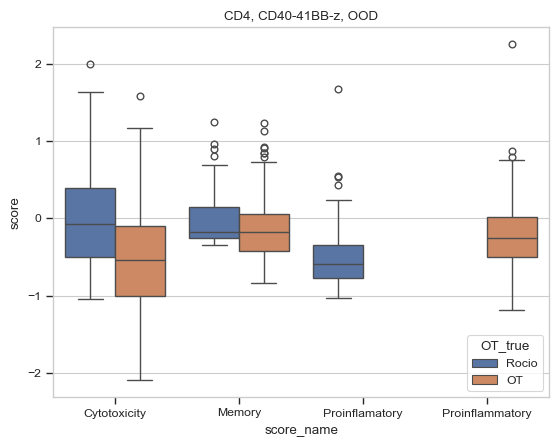

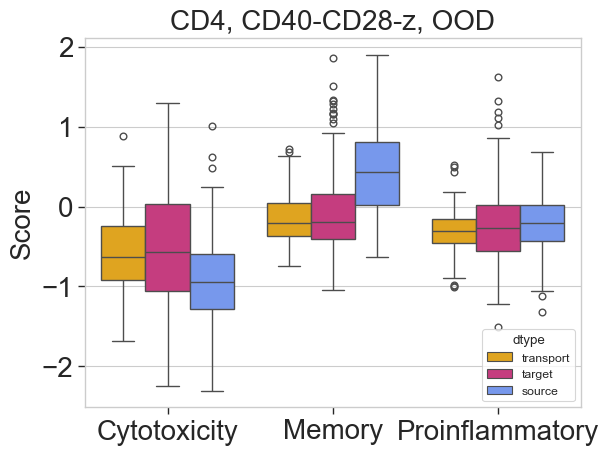

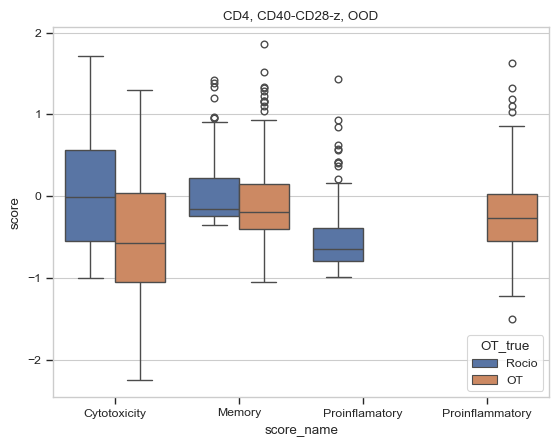

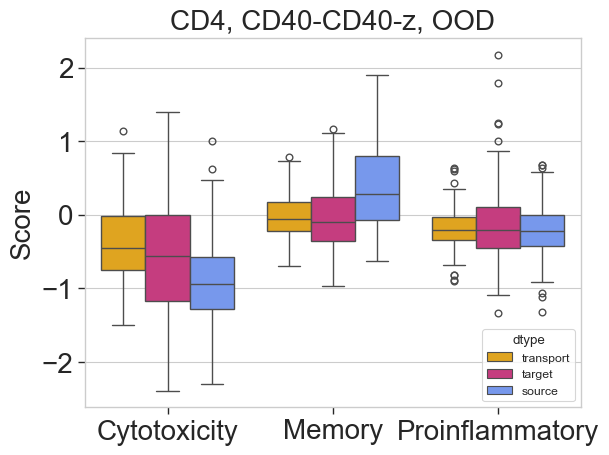

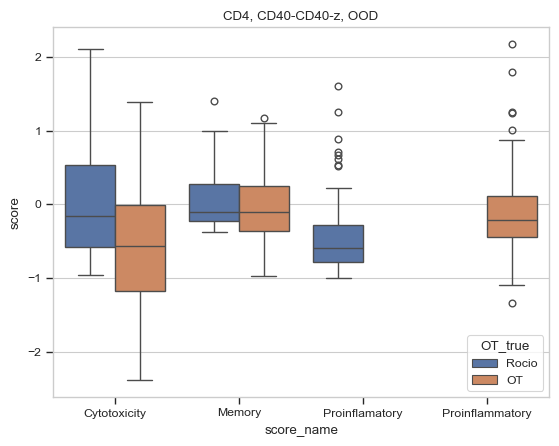

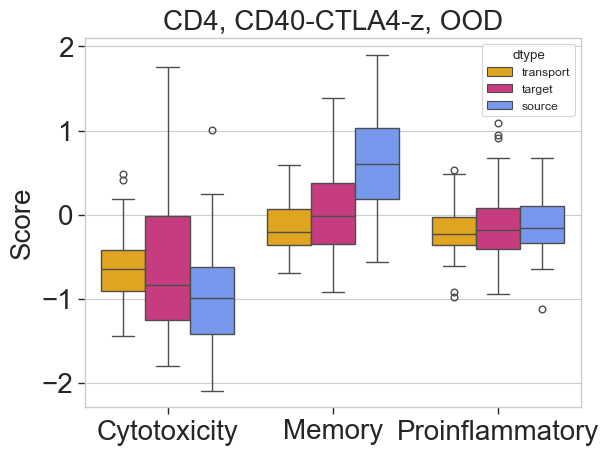

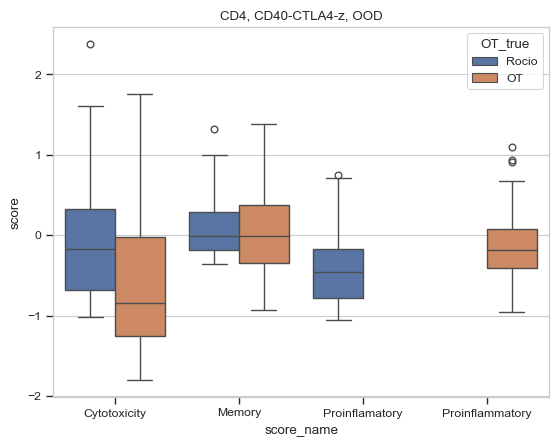

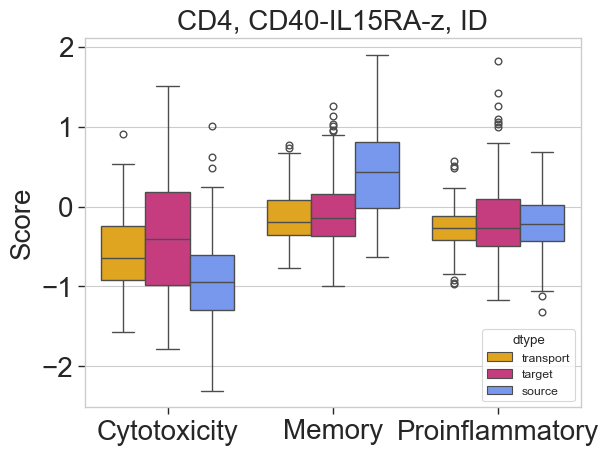

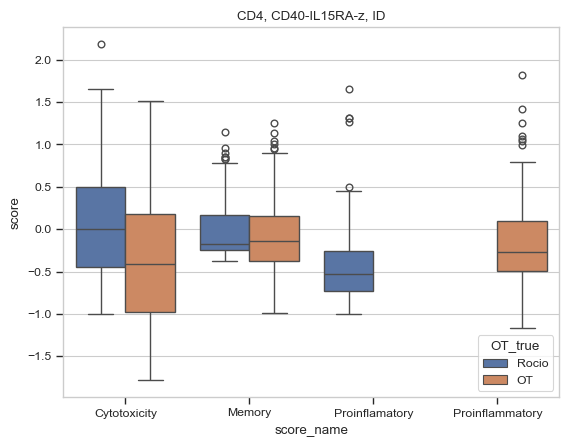

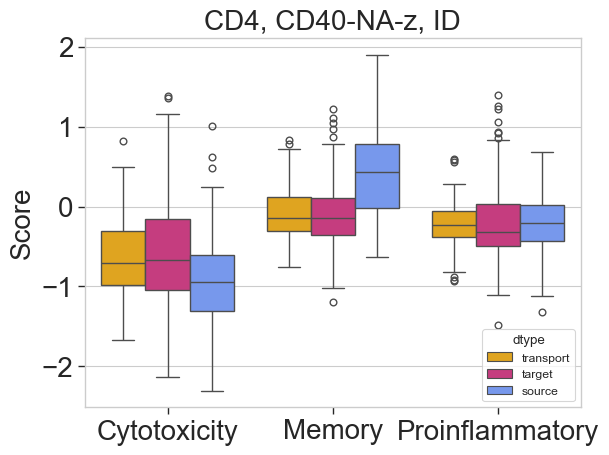

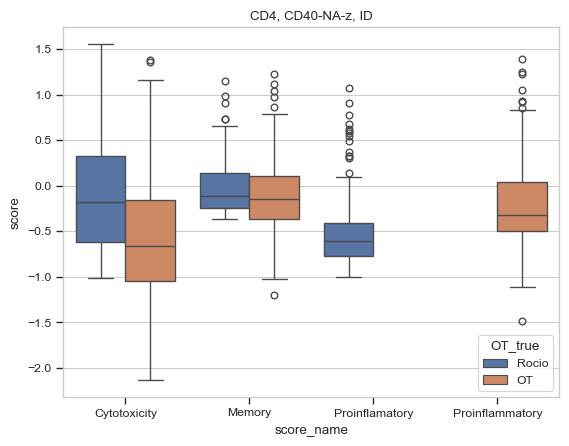

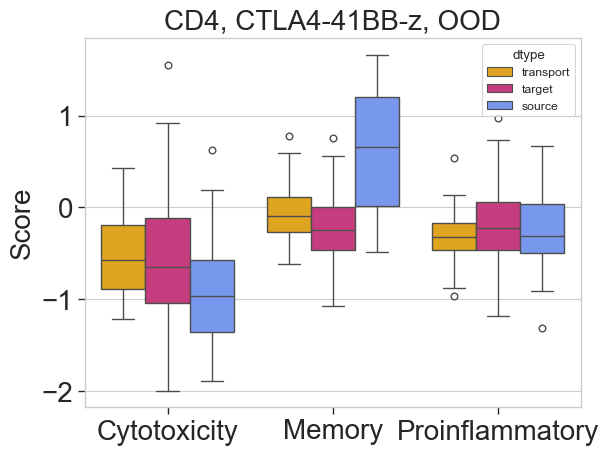

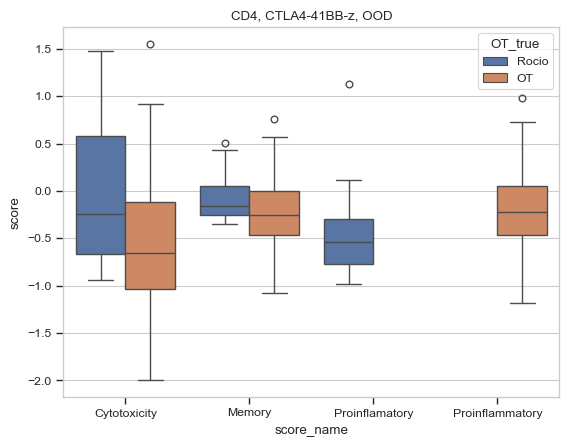

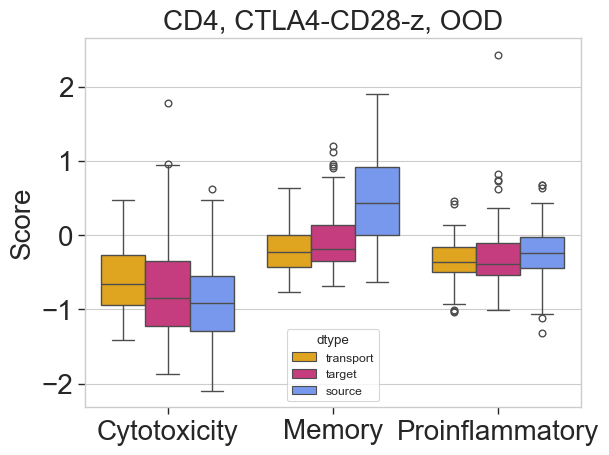

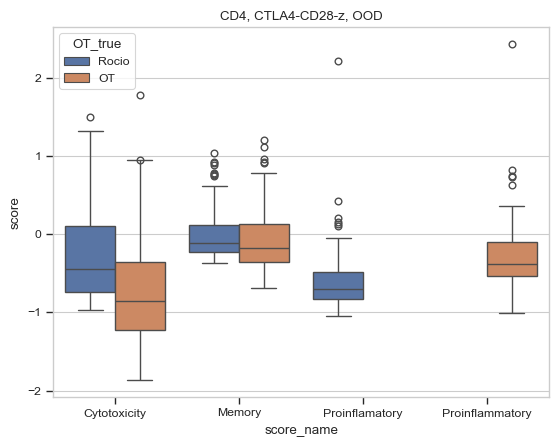

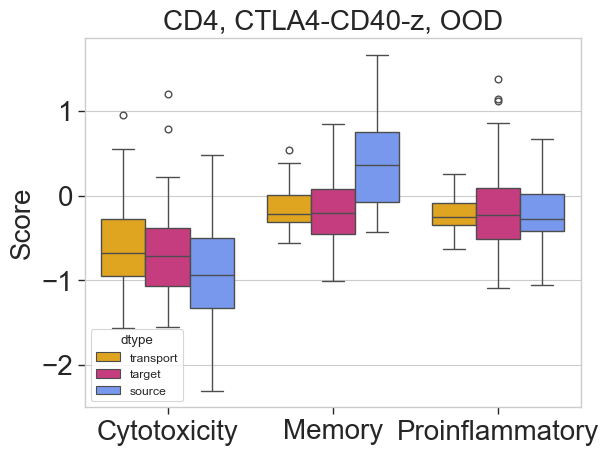

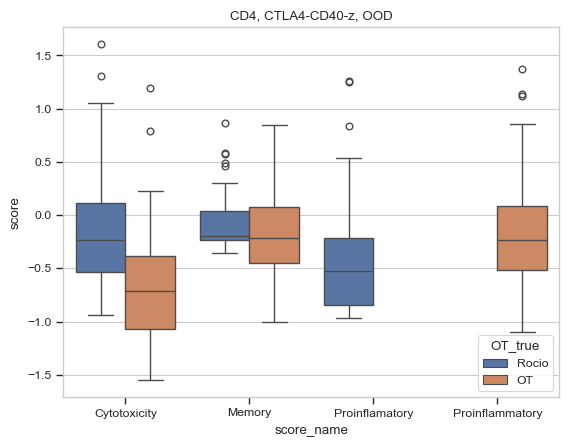

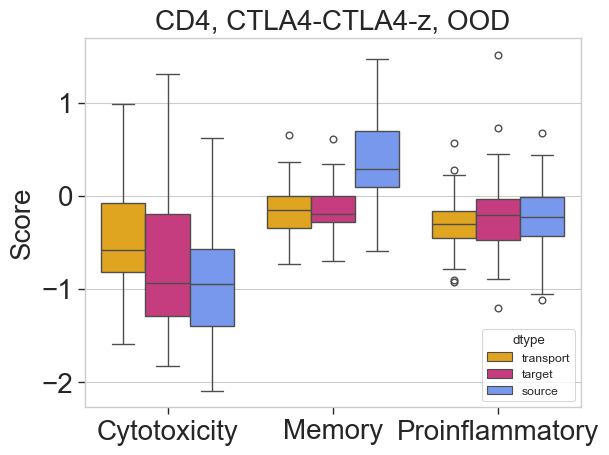

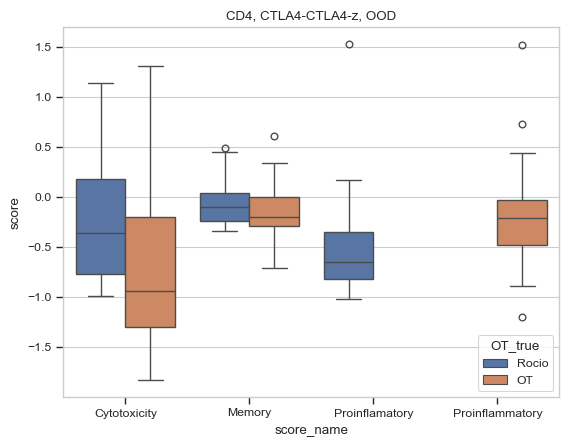

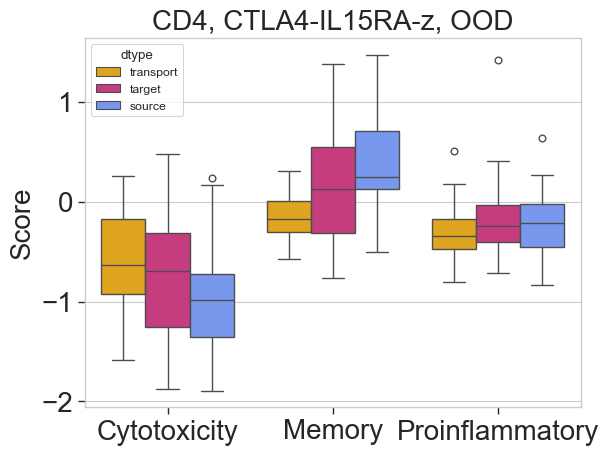

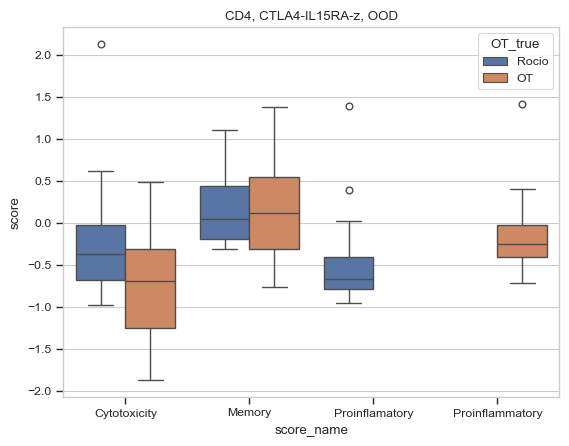

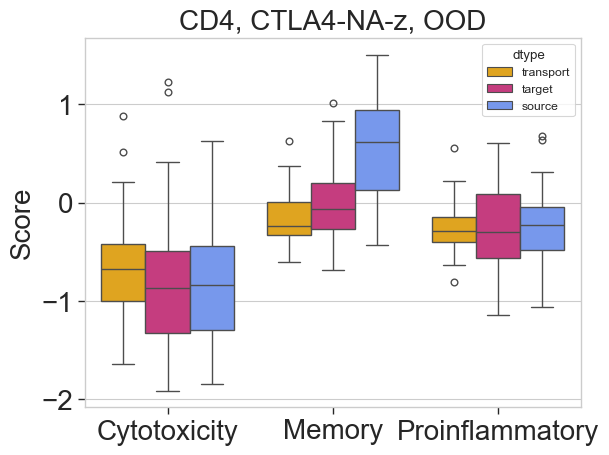

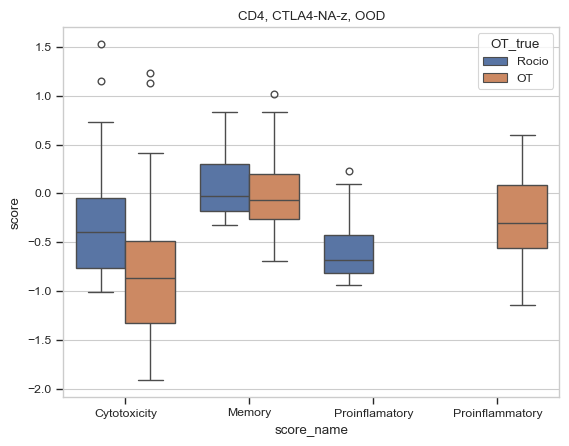

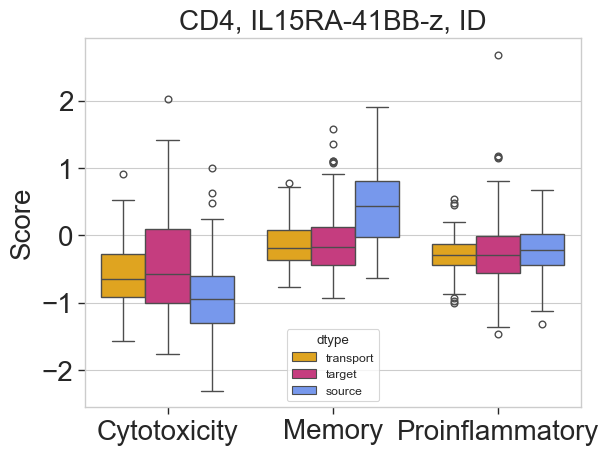

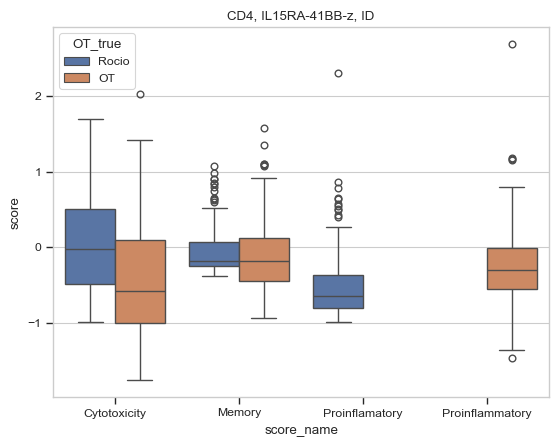

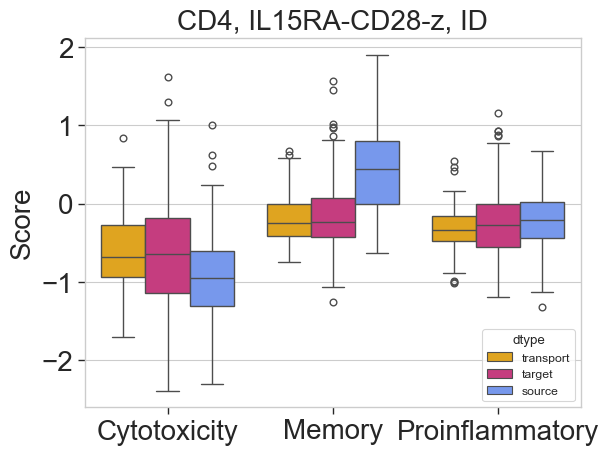

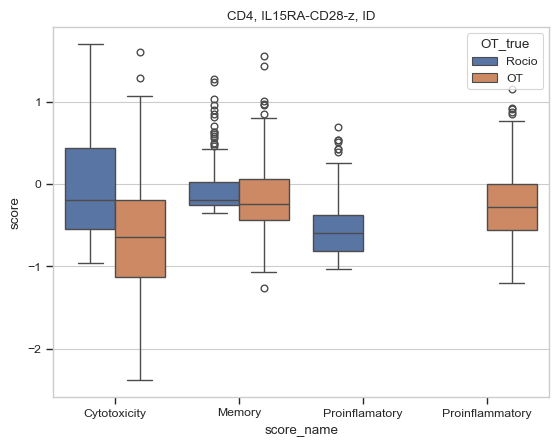

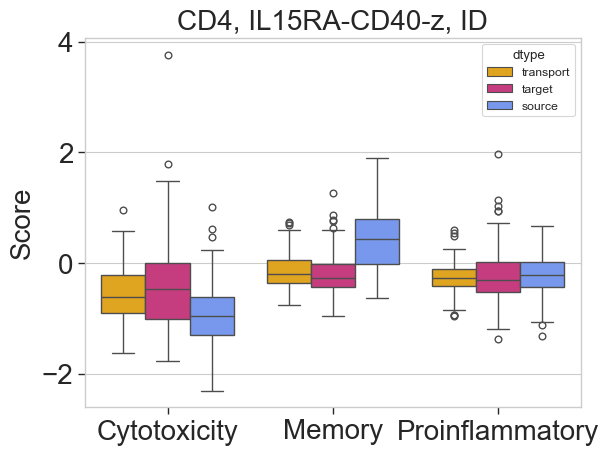

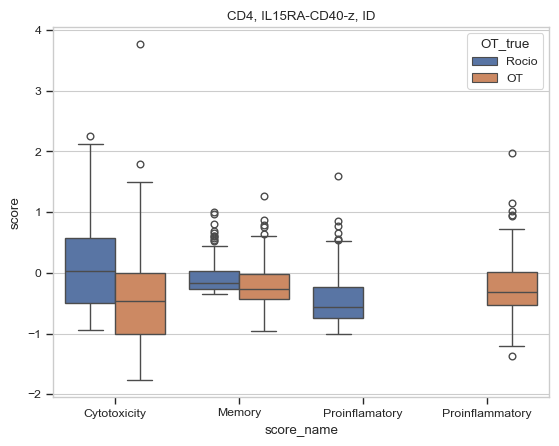

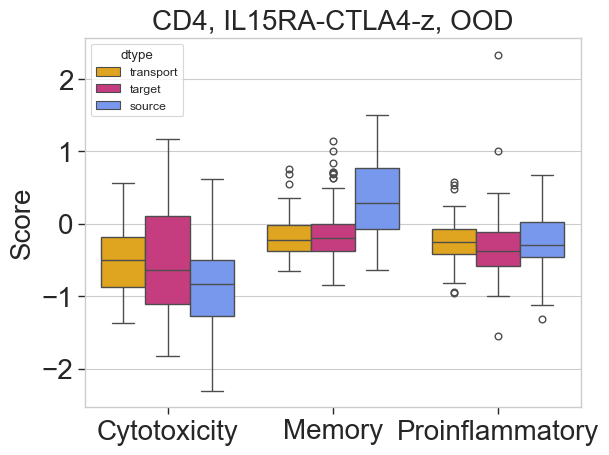

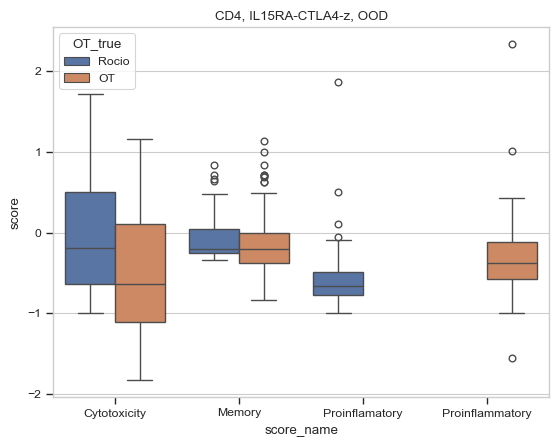

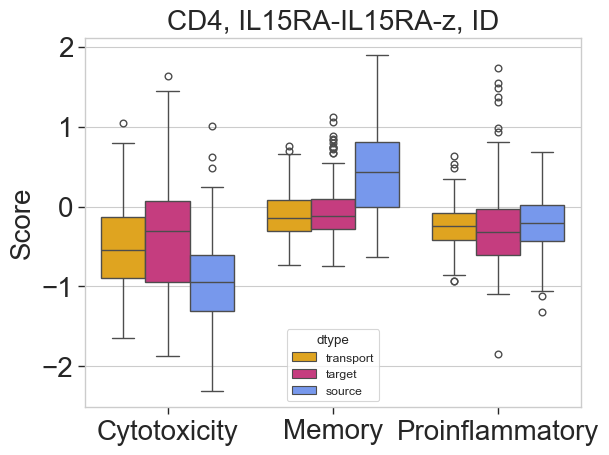

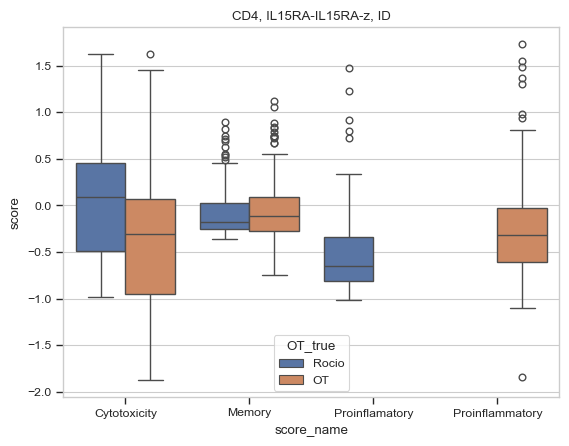

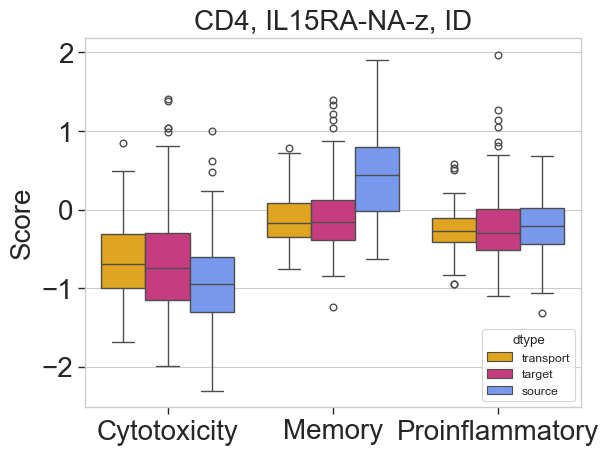

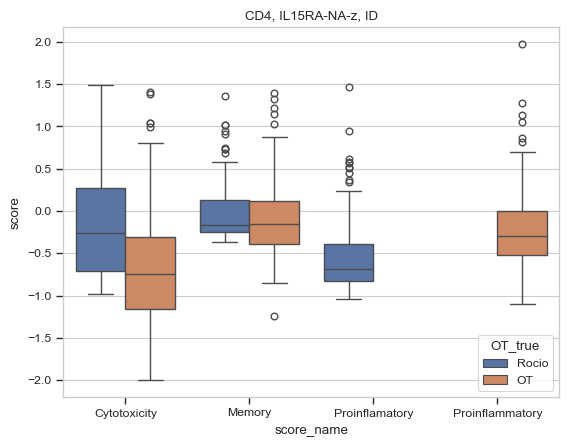

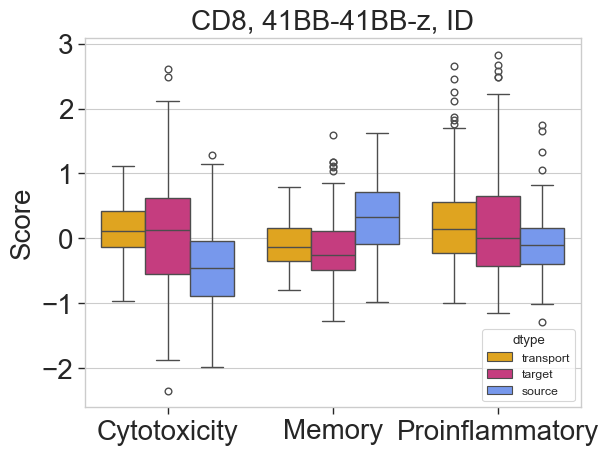

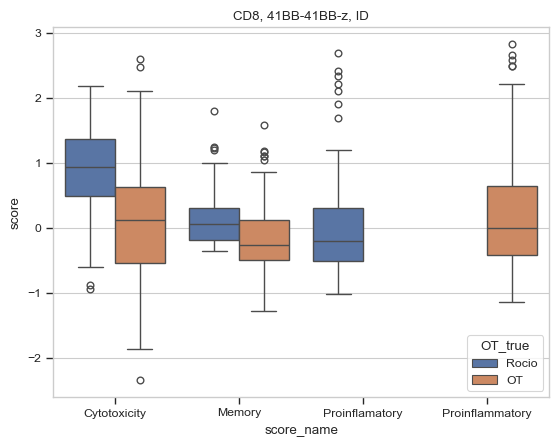

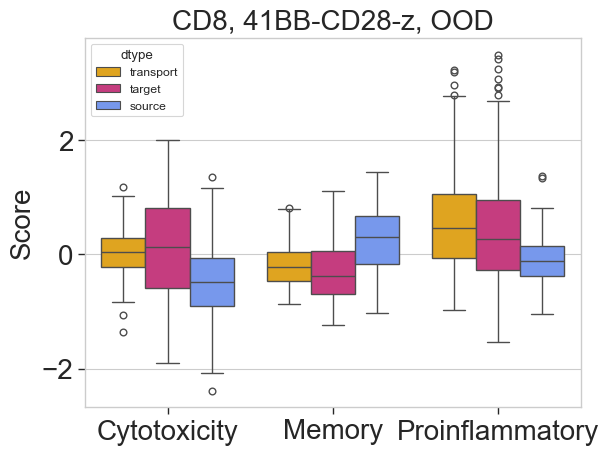

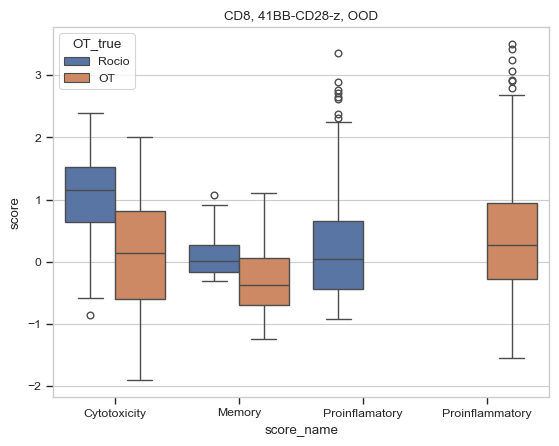

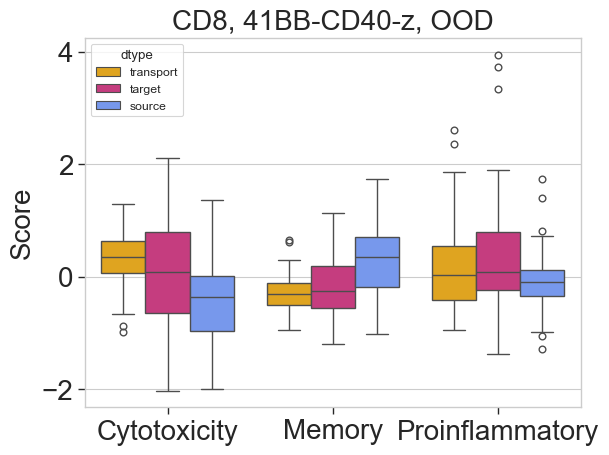

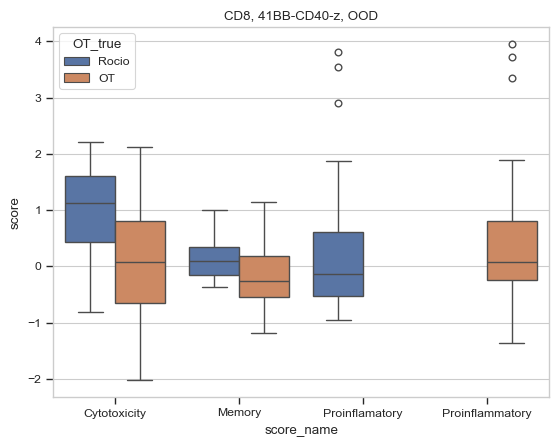

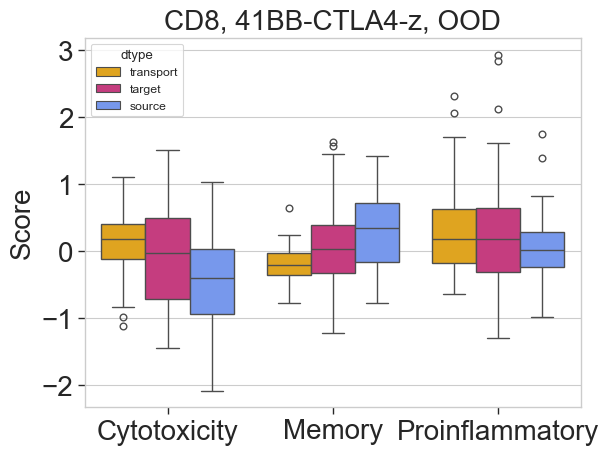

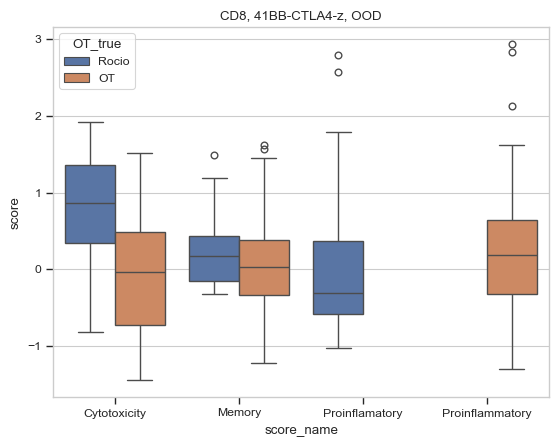

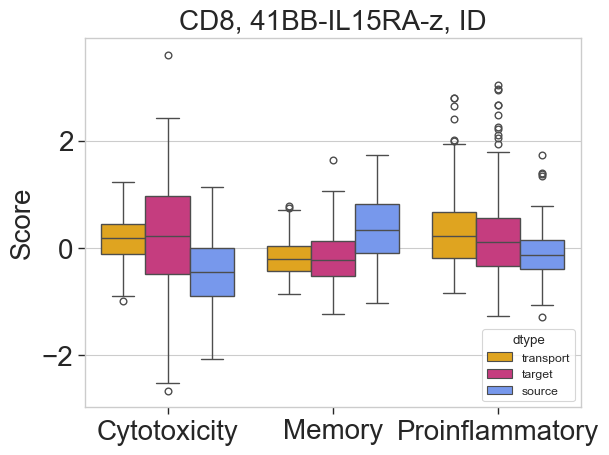

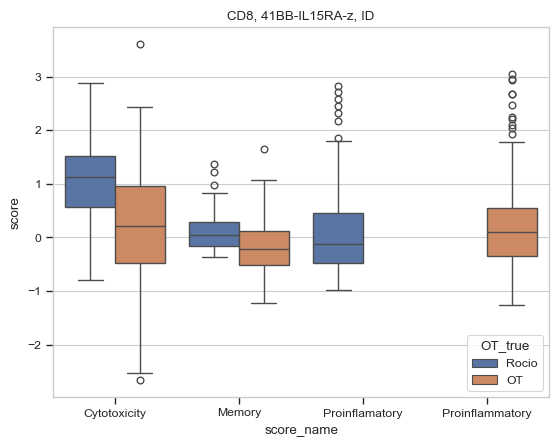

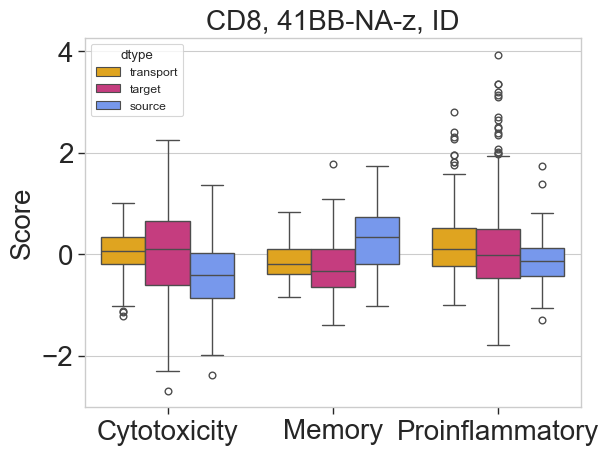

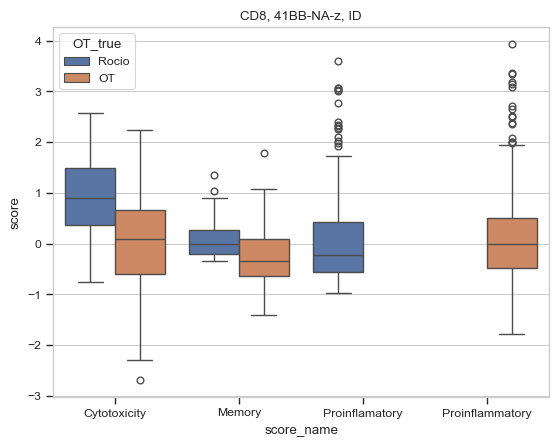

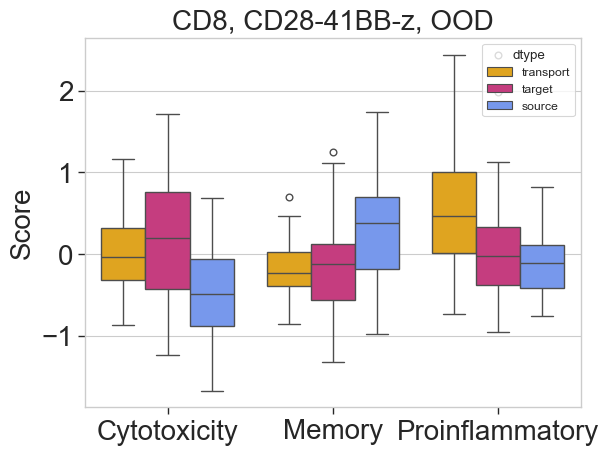

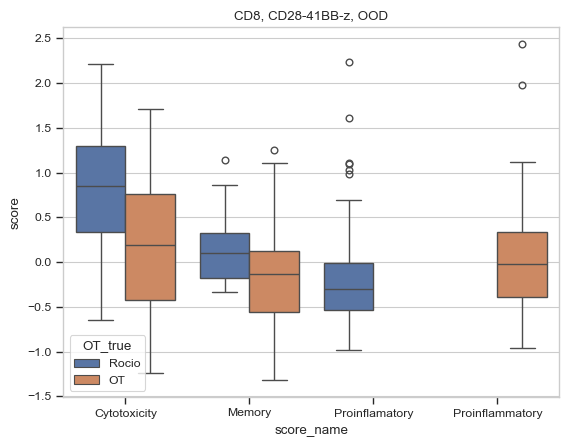

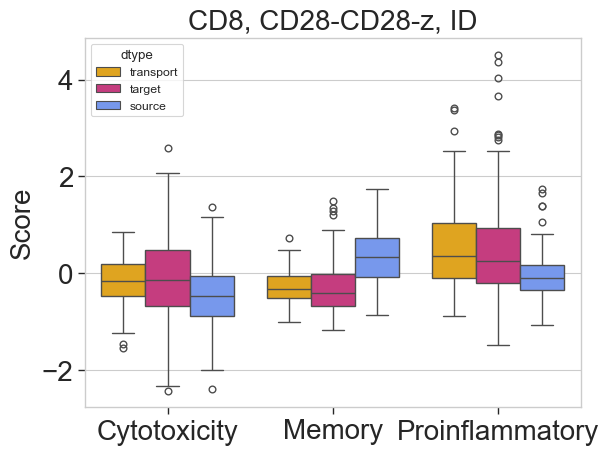

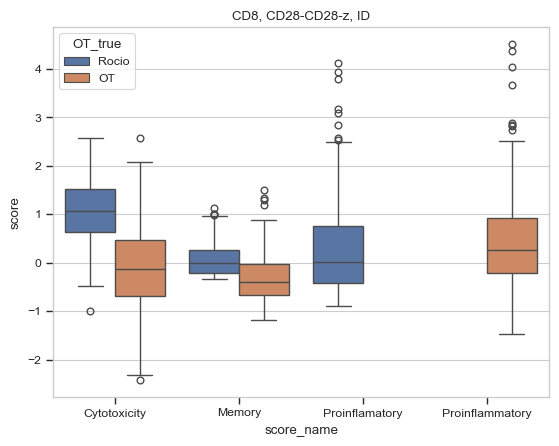

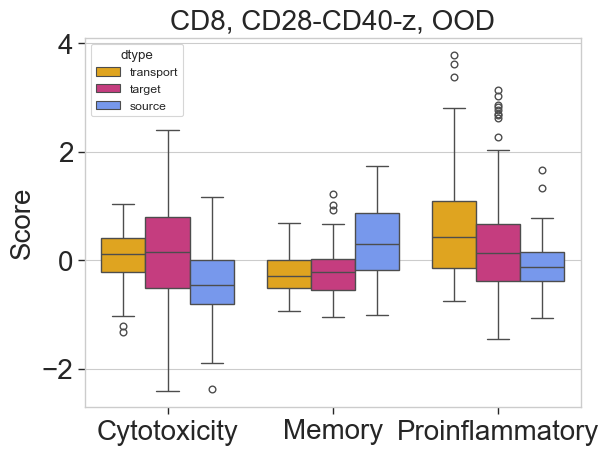

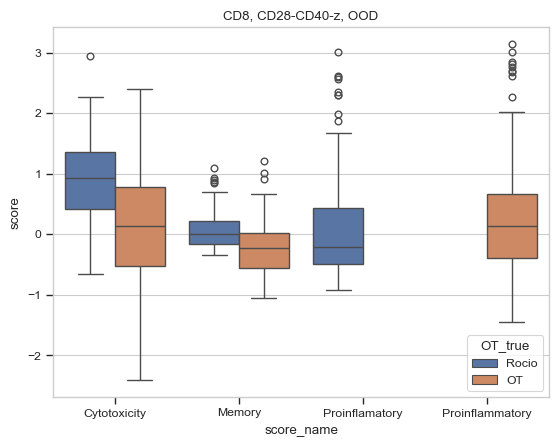

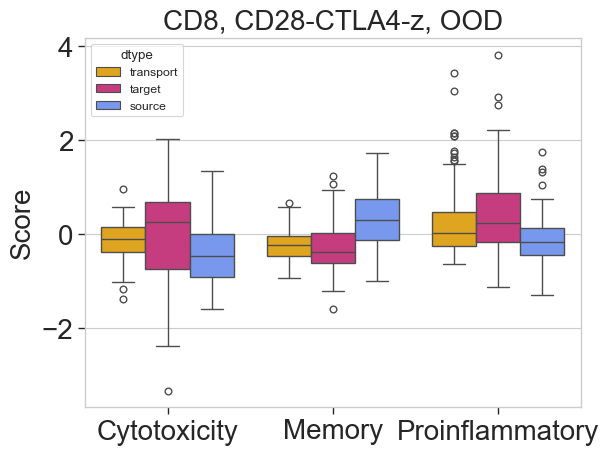

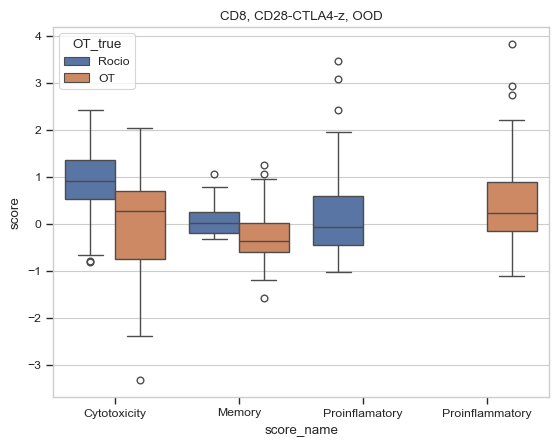

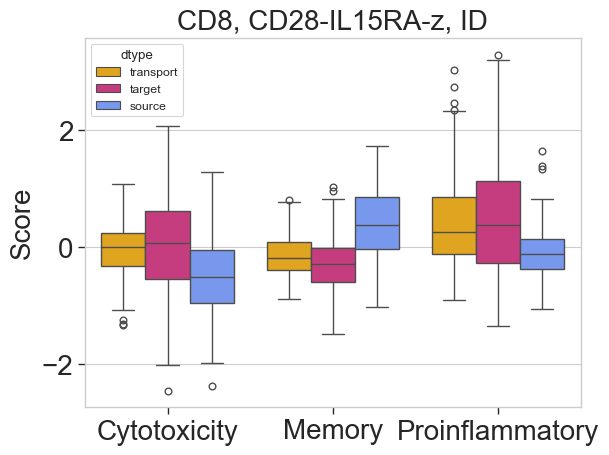

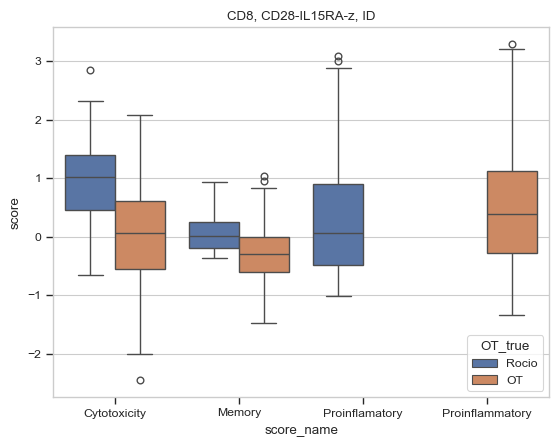

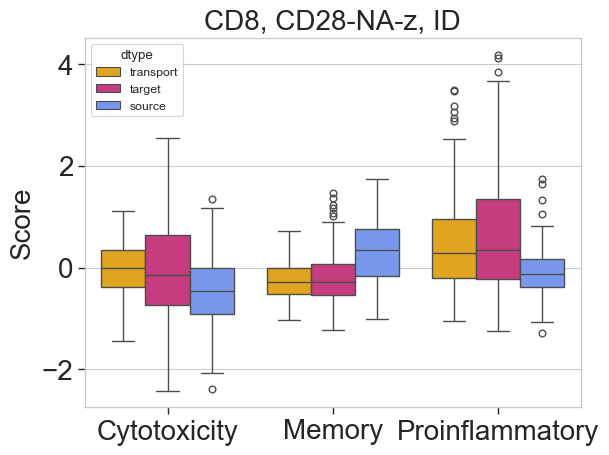

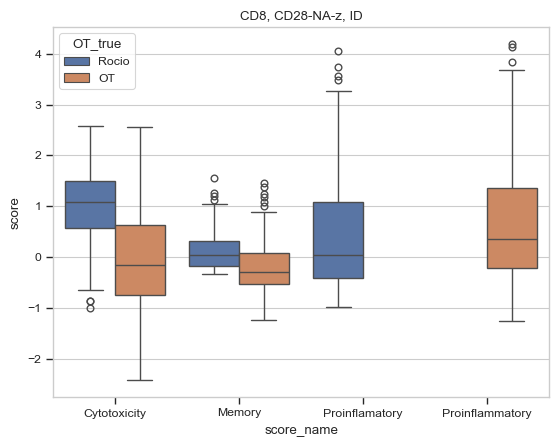

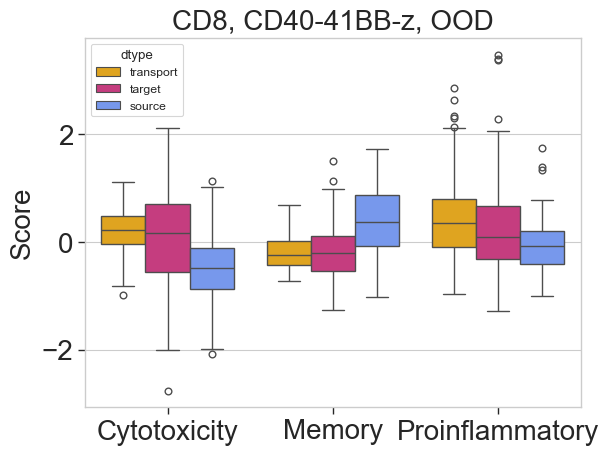

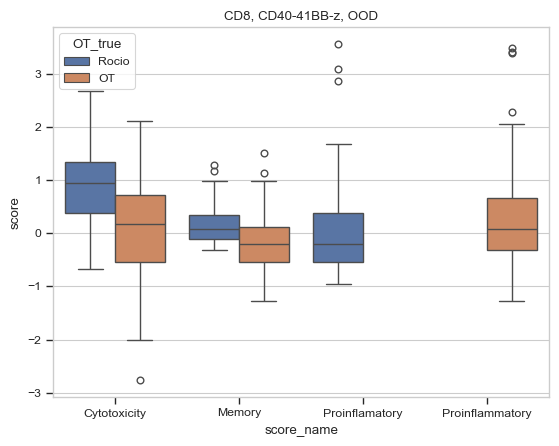

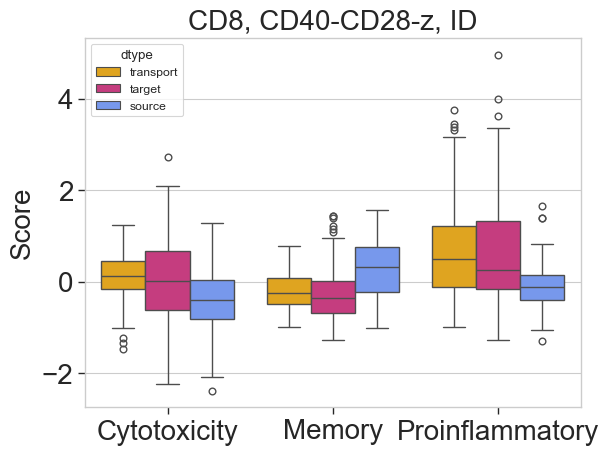

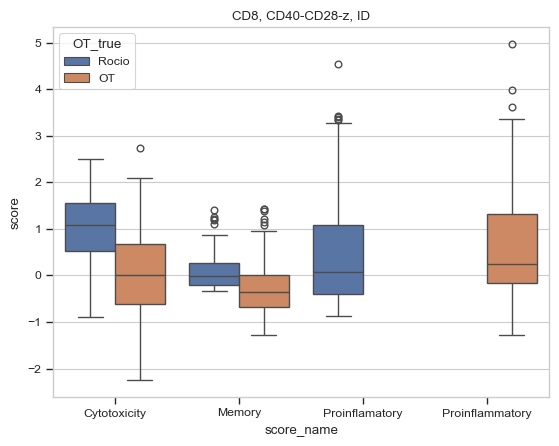

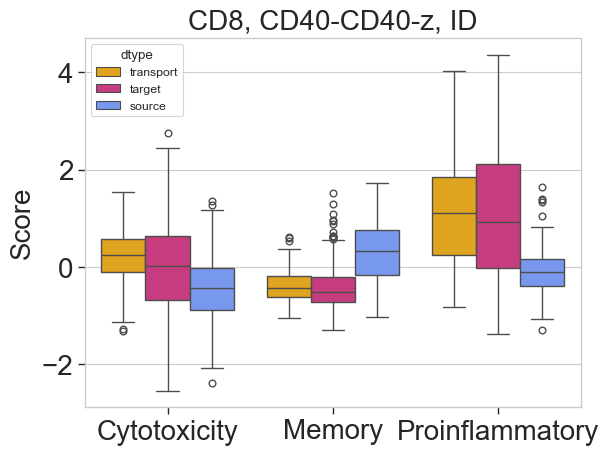

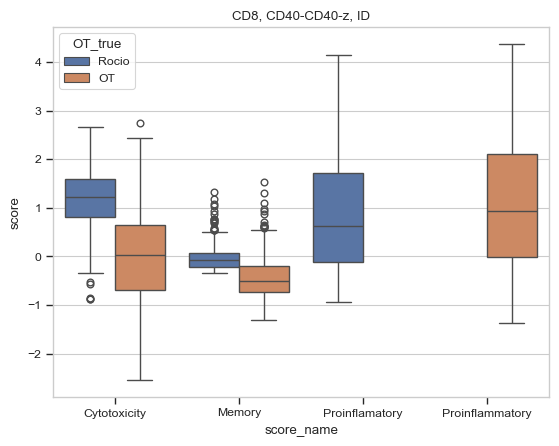

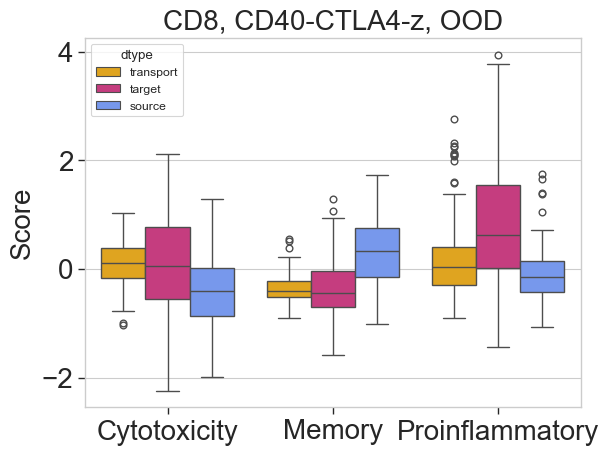

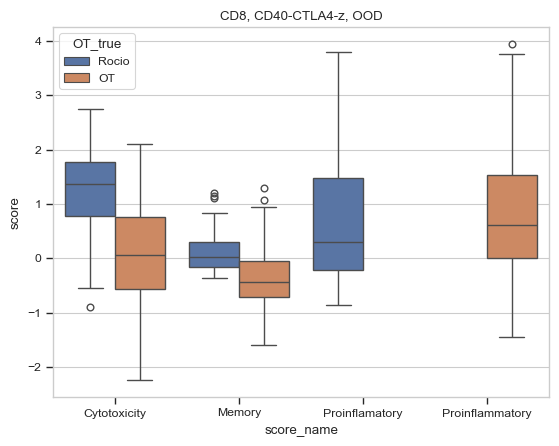

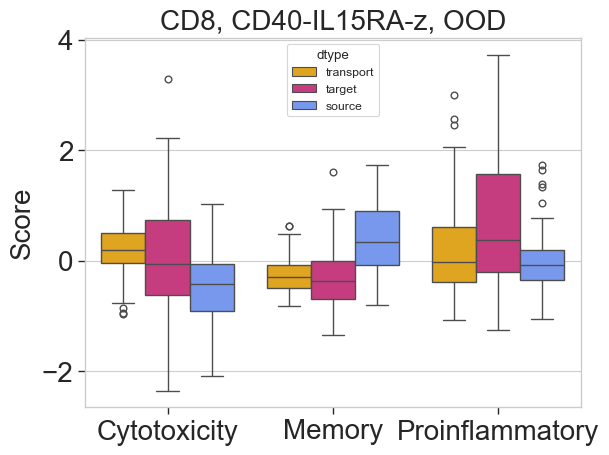

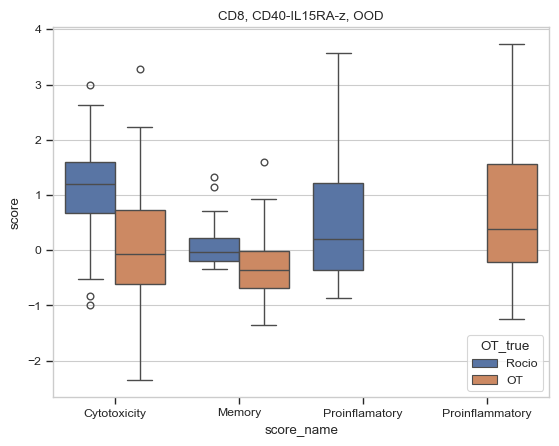

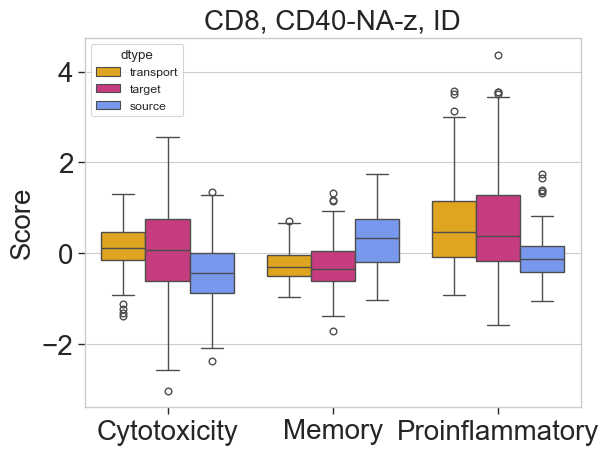

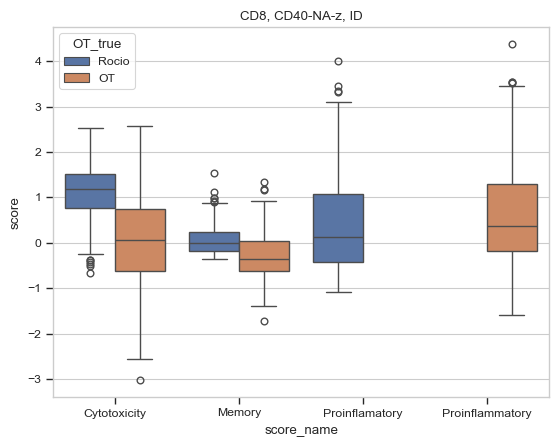

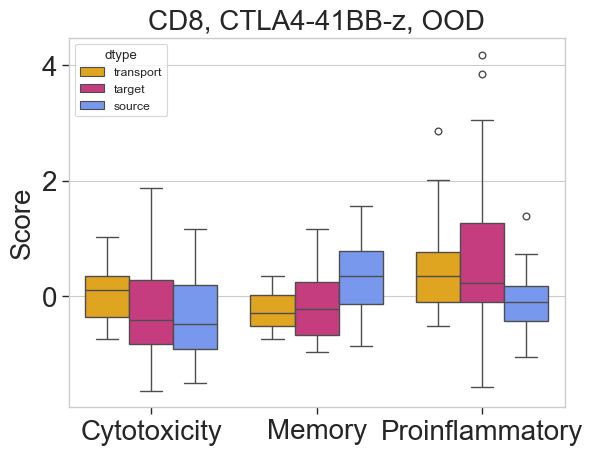

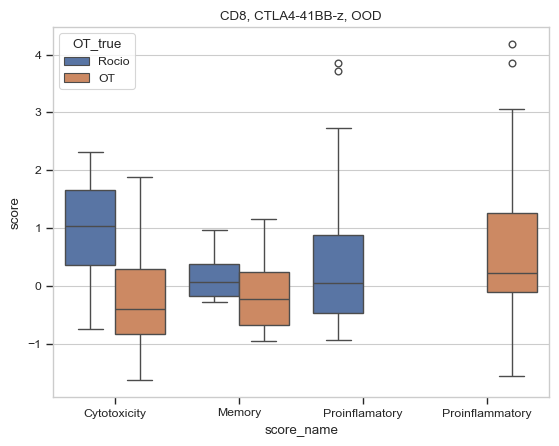

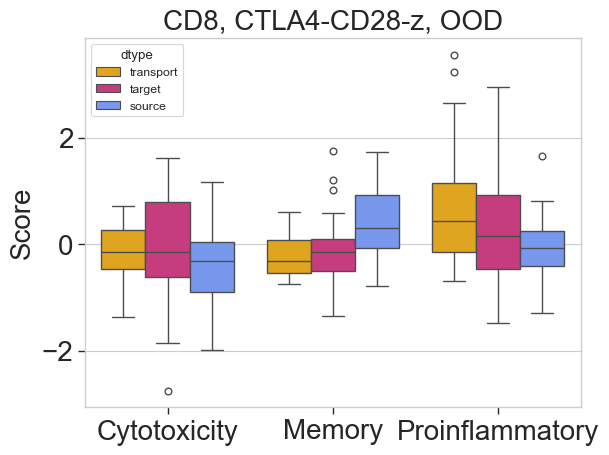

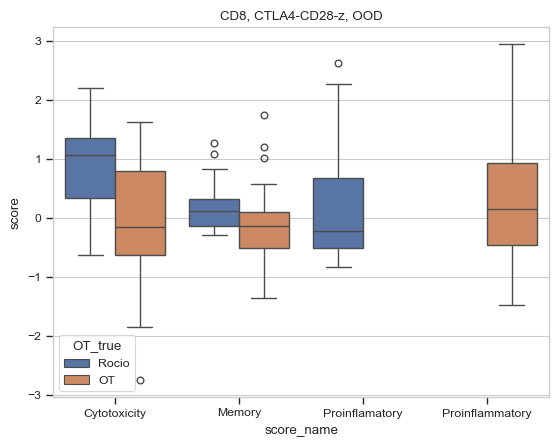

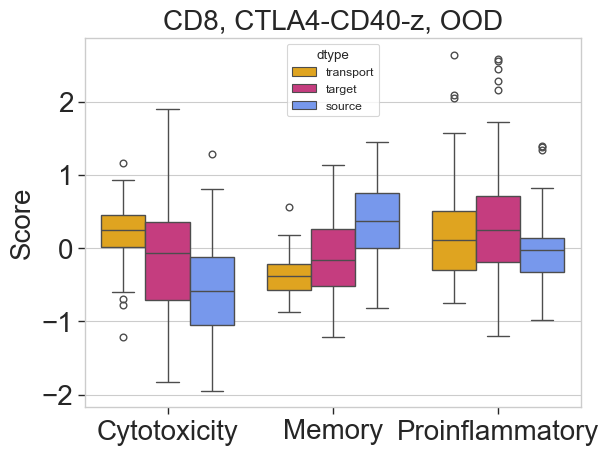

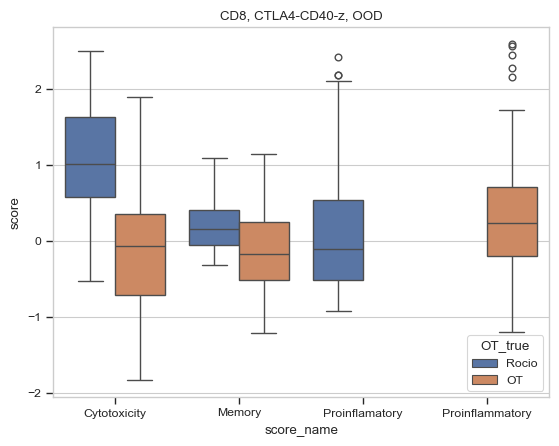

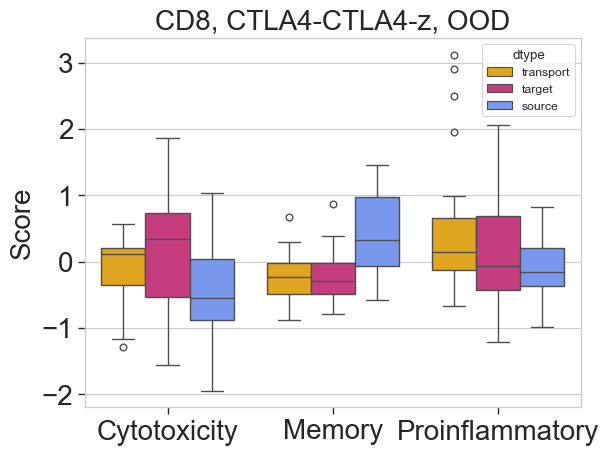

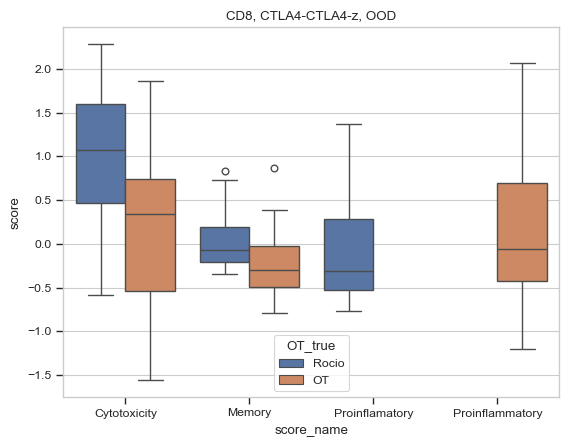

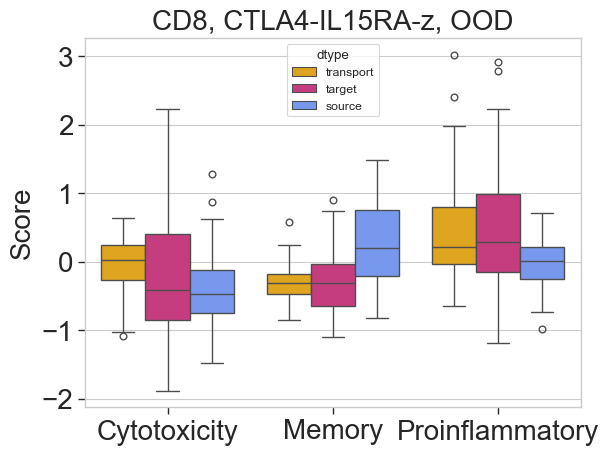

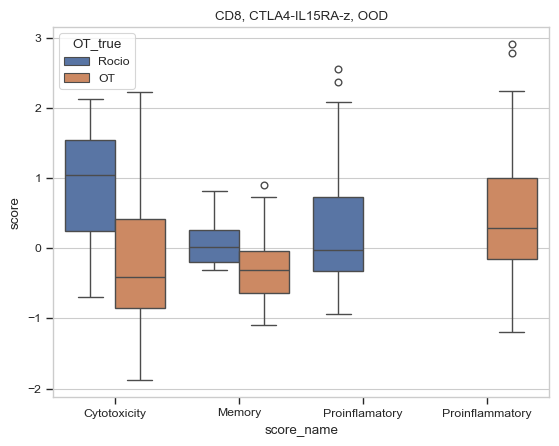

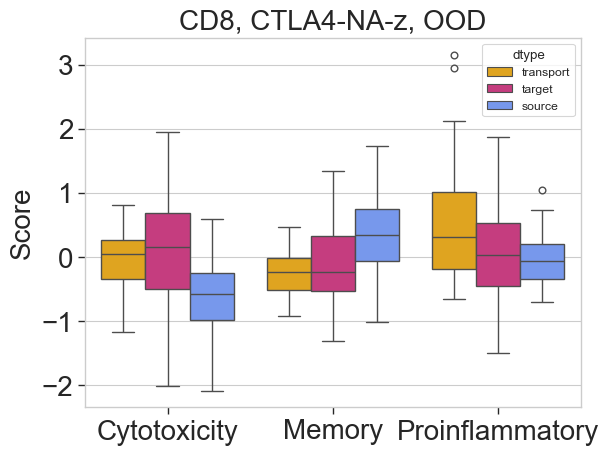

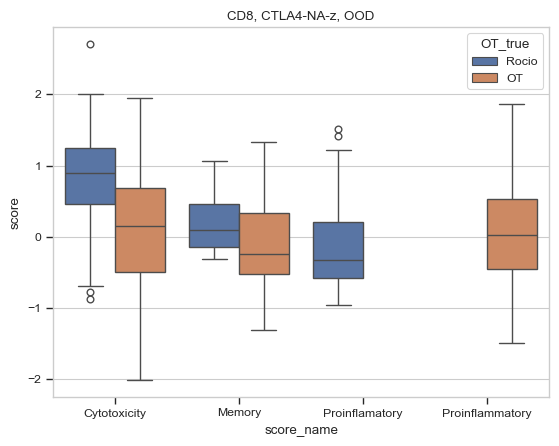

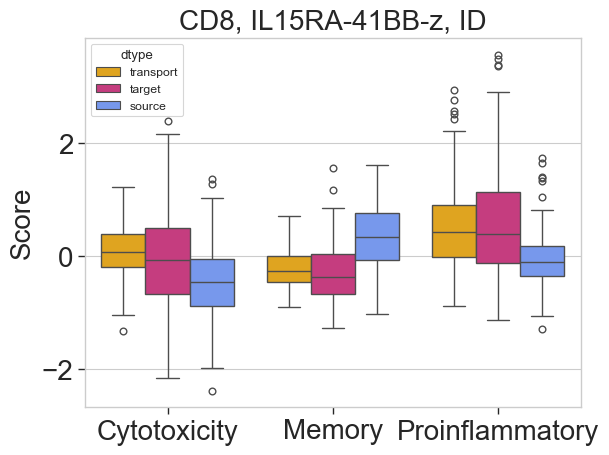

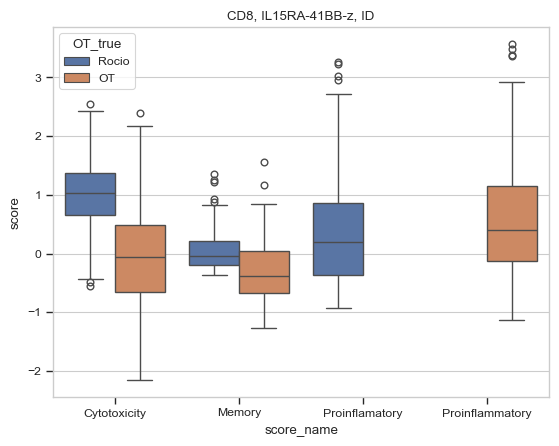

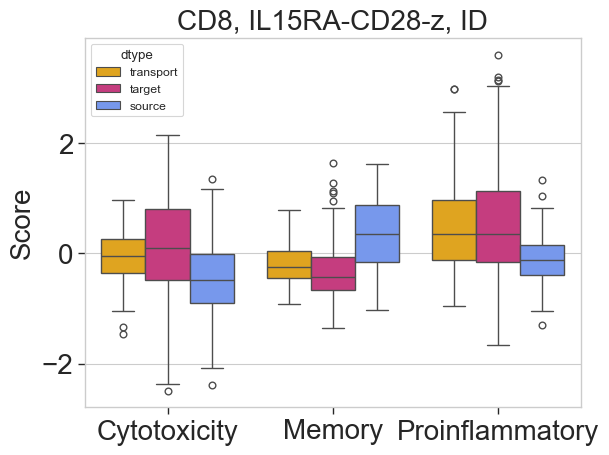

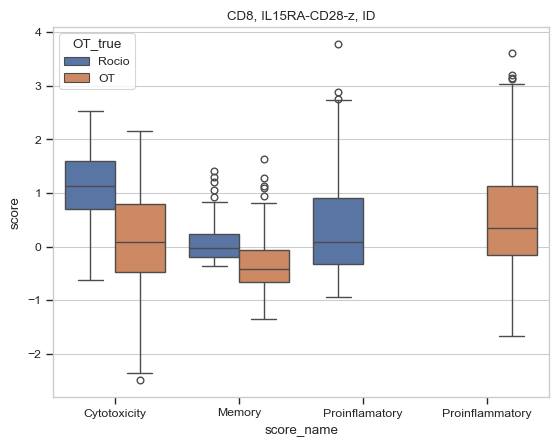

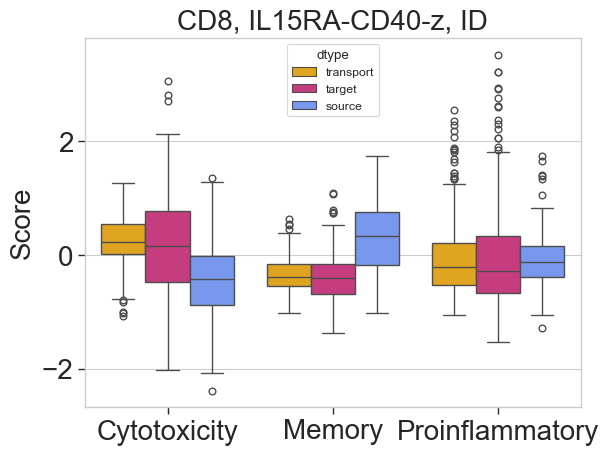

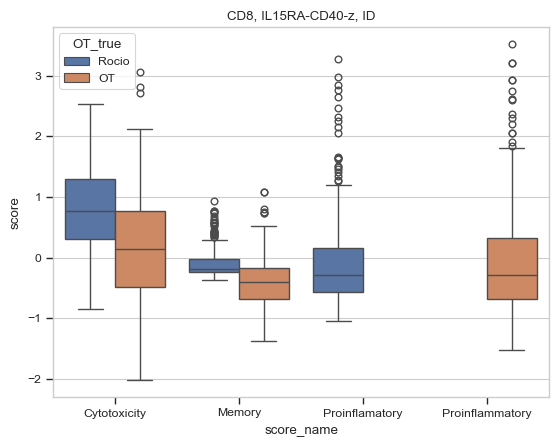

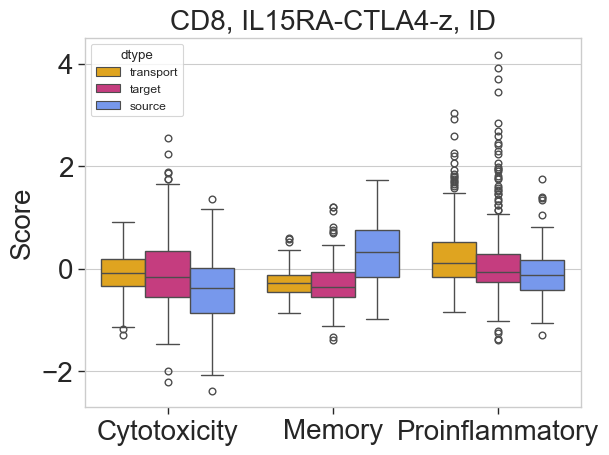

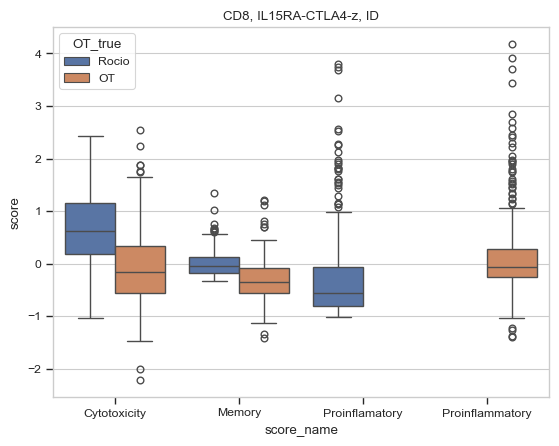

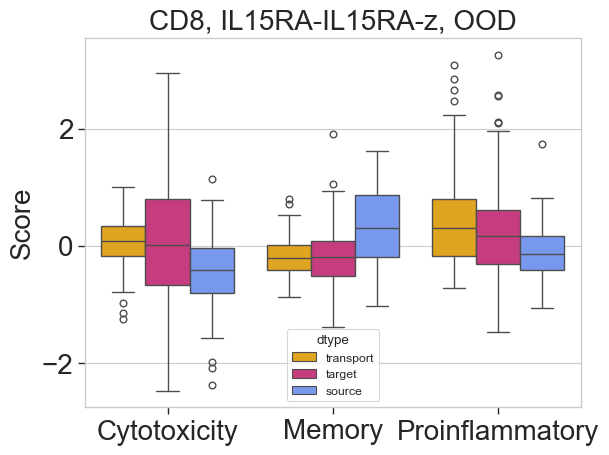

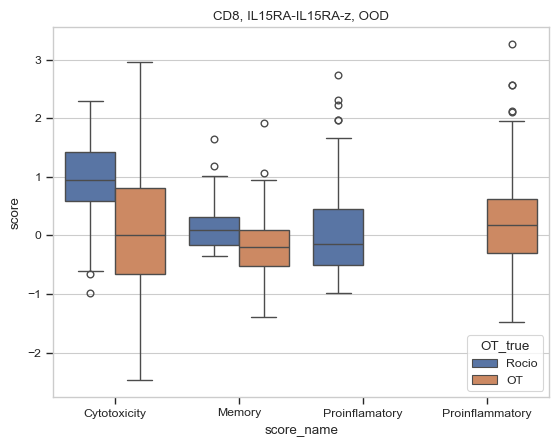

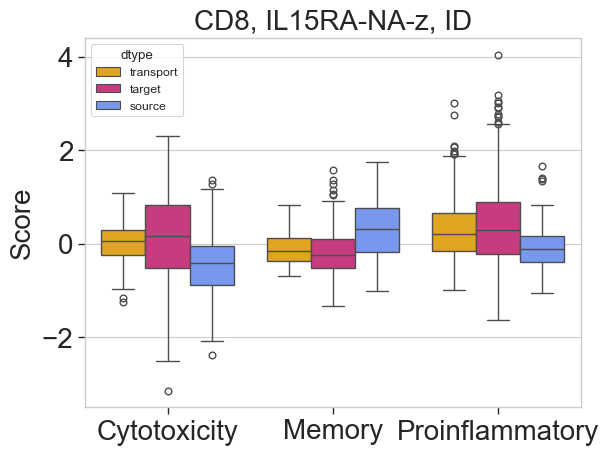

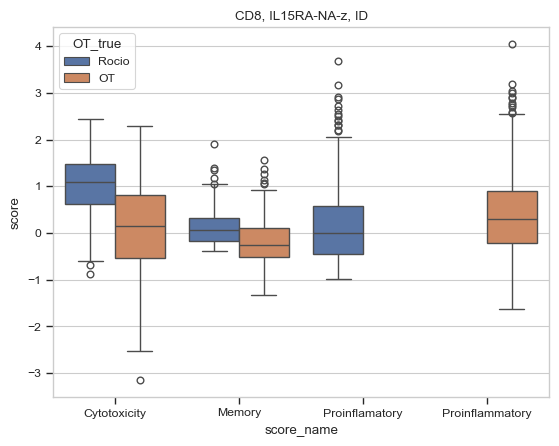

In [22]:
for subset in ["CD4", "CD8"]:
    res = adata[adata.obs["subset"]==subset]
    for car in res.obs["condition"].unique():
        data1 = res[(res.obs["dtype"]=="transport")&(res.obs["condition"]==car)].obs.loc[:, ["Cytotoxicity_1", "Memory_3", "Proinflamatory_2",
                                                                                    "Cytotoxicity_OT", "Memory_OT", "Proinflammatory_OT"]]
        data1 = data1.reset_index().melt(id_vars="index", value_name="score", var_name="OT_true")
        data1[["score_name", "OT_true"]] = [s.split("_") for s in data1["OT_true"]]
        data1.loc[data1["OT_true"]!="OT", "OT_true"] = "Rocio"
        data1['dtype'] = "transport"
    
        data2 = res[(res.obs["dtype"]=="target")&(res.obs["condition"]==car)].obs.loc[:, ["Cytotoxicity_1", "Memory_3", "Proinflamatory_2",
                                                                                    "Cytotoxicity_OT", "Memory_OT", "Proinflammatory_OT"]]
        data2 = data2.reset_index().melt(id_vars="index", value_name="score", var_name="OT_true")
        data2[["score_name", "OT_true"]] = [s.split("_") for s in data2["OT_true"]]
        data2.loc[data2["OT_true"]!="OT", "OT_true"] = "Rocio"
        data2['dtype'] = "target"
    
        data3 = res[(res.obs["dtype"]=="source")&(res.obs["condition"]==car)].obs.loc[:, ["Cytotoxicity_1", "Memory_3", "Proinflamatory_2",
                                                                                    "Cytotoxicity_OT", "Memory_OT", "Proinflammatory_OT"]]
        data3 = data3.reset_index().melt(id_vars="index", value_name="score", var_name="OT_true")
        data3[["score_name", "OT_true"]] = [s.split("_") for s in data3["OT_true"]]
        data3.loc[data3["OT_true"]!="OT", "OT_true"] = "Rocio"
        data3['dtype'] = "source"
    
        # data1.loc[data1["OT_true"]=="true", "score"] = data2.loc[data2["OT_true"]=="true", "score"].values
        data=pd.concat([data1, data2, data3])
        data["CAR_Variant"] = car
        data["subset"] = subset
        
        sns.boxplot(data=data[data["OT_true"]=="OT"], x="score_name", y="score", hue="dtype", palette=ot_map, hue_order=["transport", "target", "source"])
        plt.title(f"{subset}, {car}, {'ID' if car in sel_cars[subset] else 'OOD'}", fontsize=20)
        plt.xlabel("")
        plt.ylabel("Score", fontsize=20)
        plt.tick_params(which="both", axis="both", labelsize=20)
        plt.savefig(f"{base_fig_save}{subset}_{car}_score_comparison_box.pdf", bbox_inches="tight")
        plt.show()

        sns.boxplot(data=data[data["dtype"]=="target"], x="score_name", y="score", hue="OT_true")
        plt.title(f"{subset}, {car}, {'ID' if car in sel_cars[subset] else 'OOD'}")
        plt.show()



# Threshold determination

In [23]:
all_adata = sc.read_h5ad(f"/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Data/D09D17/20240229_from_rocio_for_manuscript.h5ad")
all_adata.X = all_adata.layers["logcounts"]
sc.tl.score_genes(all_adata, genesets["Cytotoxicity"], score_name="Cytotoxicity_OT")
sc.tl.score_genes(all_adata, genesets["Proinflammatory"], score_name="Proinflammatory_OT")
sc.tl.score_genes(all_adata, genesets["Memory"], score_name="Memory_OT")

In [24]:
all_adata

AnnData object with n_obs × n_vars = 58949 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'CAR_Variant', 'Donor', 'Time', 'Lane', 'Sample', 'percent.mt', 'A', 'B', 'C', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'RNA_snn_res.0.75', 'seurat_clusters', 'subset_RNA', 'subset_ADT', 'subset', 'Cytotoxicity_1', 'Proinflamatory_2', 'Memory_3', 'CD4_Th1_4', 'CD4_Th2_5', 'ident', 'Cytotoxicity_OT', 'Proinflammatory_OT', 'Memory_OT'
    obsm: 'HARMONY', 'X_pca', 'X_umap'
    layers: 'logcounts'

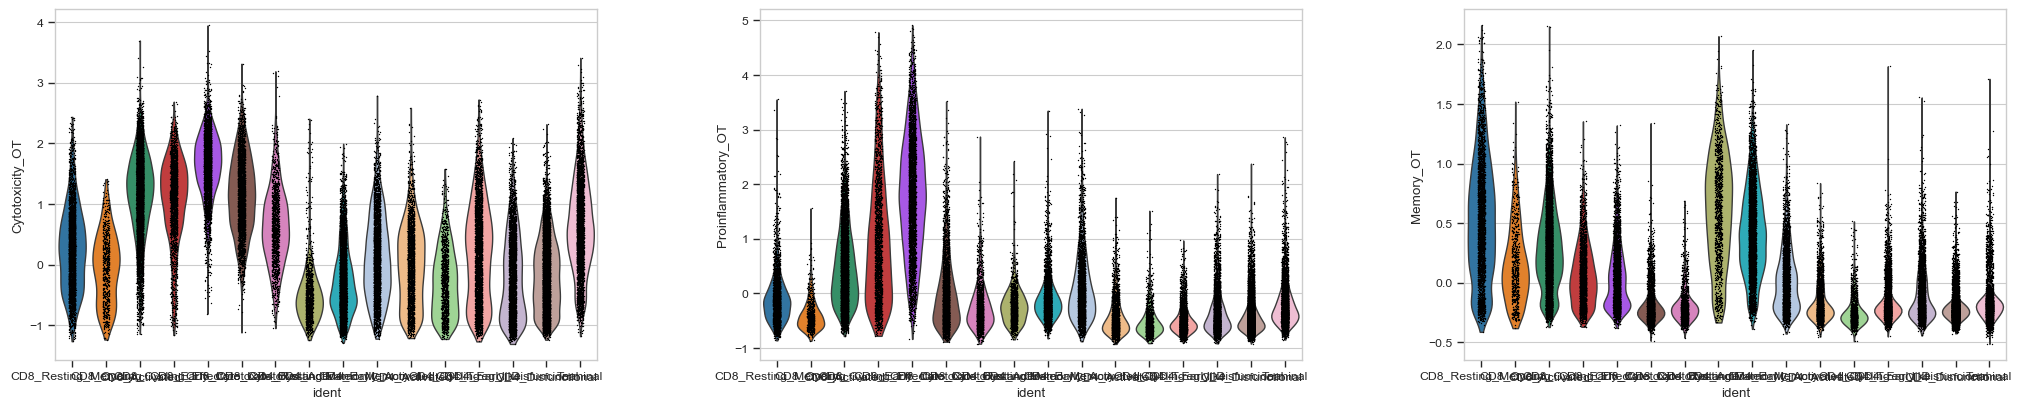

In [25]:
g=sc.pl.violin(all_adata, groupby="ident", keys=["Cytotoxicity_OT", "Proinflammatory_OT", "Memory_OT"])

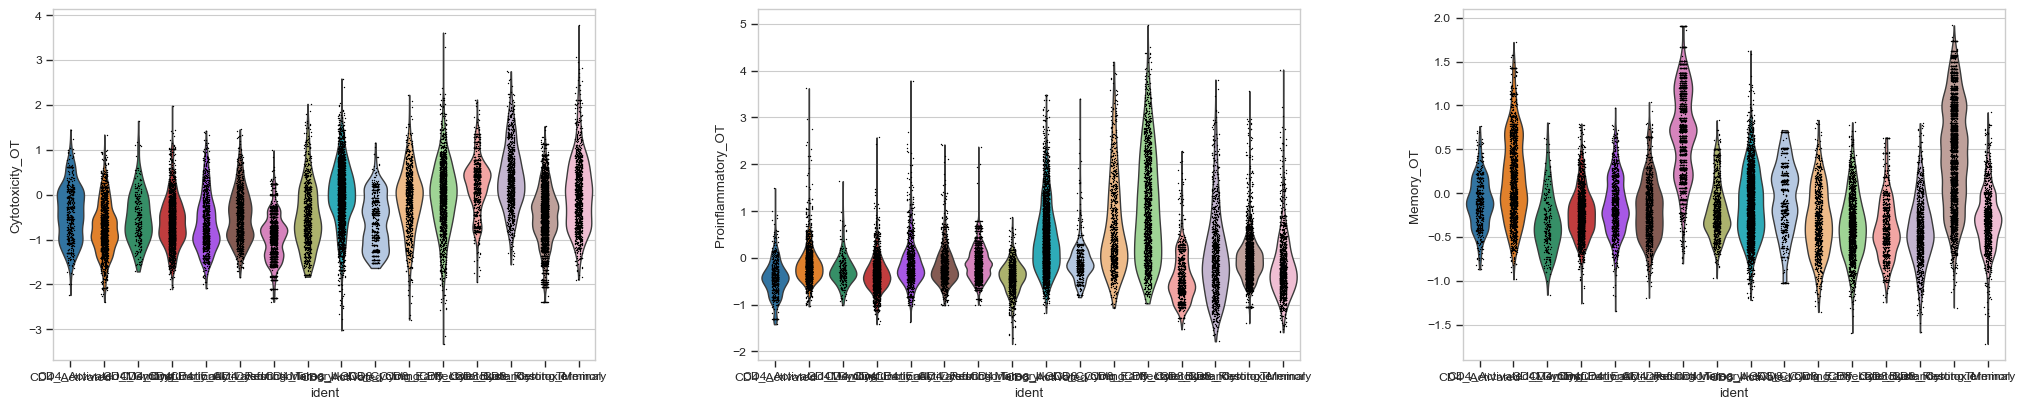

In [26]:
g = sc.pl.violin(adata, groupby="ident", keys=["Cytotoxicity_OT", "Proinflammatory_OT", "Memory_OT"])

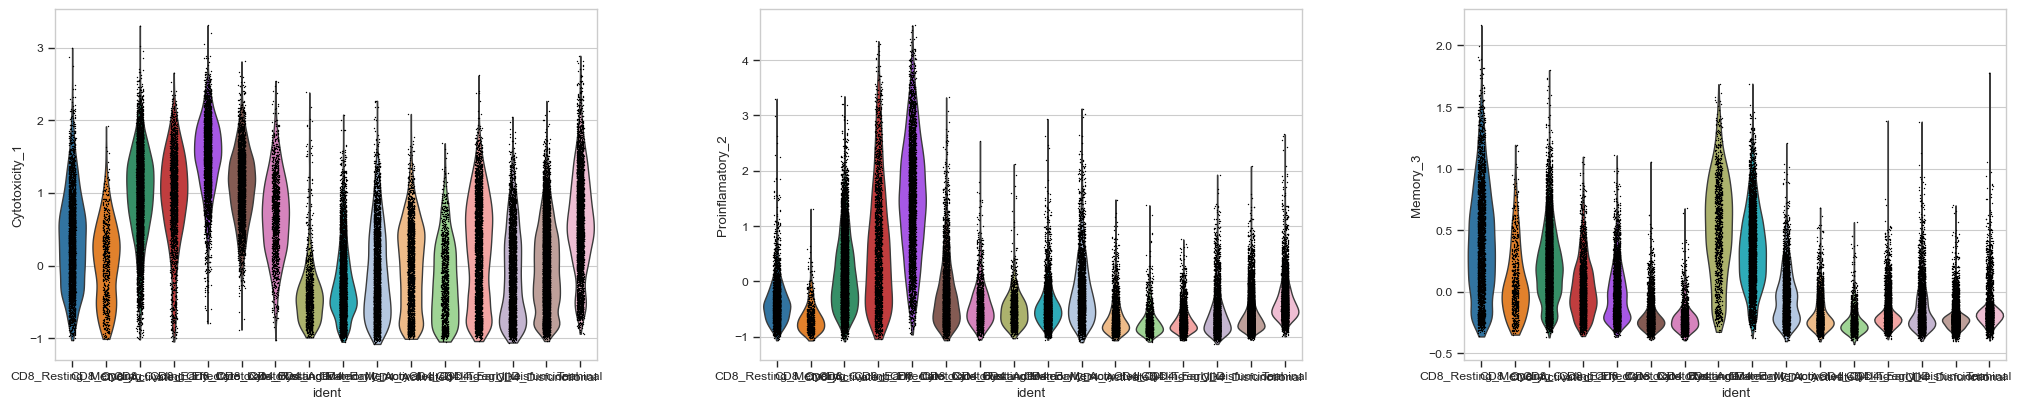

In [27]:
sc.pl.violin(all_adata, groupby="ident", keys=["Cytotoxicity_1", "Proinflamatory_2", "Memory_3"])

# Plot percentage pos

In [49]:
adata.obs["Cytox_pos"] = [s>0 for s in adata.obs["Cytotoxicity_OT"]]
adata.obs["Proinflam_pos"] = [s>1 for s in adata.obs["Proinflammatory_OT"]]
adata.obs["Mem_pos"] = [s>0 for s in adata.obs["Memory_OT"]]

In [50]:
adata.obs.loc[(adata.obs["subset"]=="CD4")&(adata.obs["CAR_Variant"].isin(sel_cars["CD4"])), "ID"] = True
adata.obs.loc[(adata.obs["subset"]=="CD4")&~(adata.obs["CAR_Variant"].isin(sel_cars["CD4"])), "ID"] = False

adata.obs.loc[(adata.obs["subset"]=="CD8")&(adata.obs["CAR_Variant"].isin(sel_cars["CD8"])), "ID"] = True
adata.obs.loc[(adata.obs["subset"]=="CD8")&~(adata.obs["CAR_Variant"].isin(sel_cars["CD8"])), "ID"] = False
adata.obs["ID"] = adata.obs["ID"].astype(bool)
adata.obs["OOD"] = ~adata.obs["ID"]

In [51]:
pos_counts = adata[adata.obs["subset"]=="CD8"].obs.groupby(["CAR_Variant", "dtype", "ID", "OOD"], observed=True).sum(numeric_only=True)[["Cytox_pos", "Proinflam_pos", "Mem_pos"]]
tot = adata.obs.groupby(["CAR_Variant", "dtype"], observed=True).size()
pos_counts["total"] = tot
pos_counts["cytox_perc"] = pos_counts["Cytox_pos"] / pos_counts["total"] * 100
pos_counts["proinf_perc"] = pos_counts["Proinflam_pos"] / pos_counts["total"] * 100
pos_counts["mem_perc"] = pos_counts["Mem_pos"] / pos_counts["total"] * 100
pos_counts = pos_counts.reset_index()
pos_counts = pos_counts[~pos_counts["CAR_Variant"].isin(["NA-NA-NA", "NA-NA-z"])]
pos_counts["CAR_Variant"] = pos_counts["CAR_Variant"].astype(str)
pos_counts["dtype"] = pos_counts["dtype"].astype(str)

In [52]:
tot

CAR_Variant      dtype    
41BB-41BB-z      target        308
                 transport     308
41BB-CD28-z      target        296
                 transport     296
41BB-CD40-z      target        245
                              ... 
IL15RA-IL15RA-z  target        273
                 transport     273
IL15RA-NA-z      target        382
                 transport     382
NA-NA-NA         source       7820
Length: 61, dtype: int64

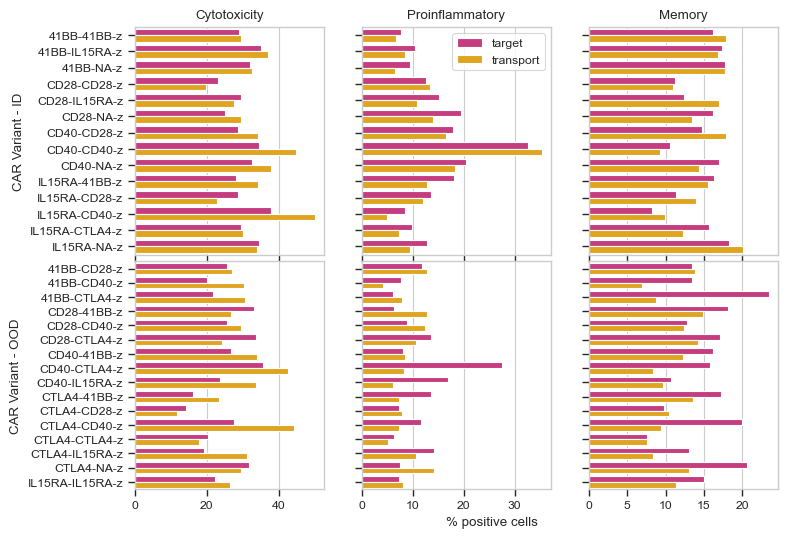

In [53]:
fig, axes = plt.subplots(2, 3, figsize=(8.3, 6), sharey='row', sharex='col')
flat_axes= axes.flat
sns.barplot(data=pos_counts[pos_counts["ID"]], x="cytox_perc", y="CAR_Variant", hue="dtype", palette=ot_map, ax=flat_axes[0])
sns.barplot(data=pos_counts[pos_counts["ID"]], x="proinf_perc", y="CAR_Variant", hue="dtype", palette=ot_map, ax=flat_axes[1])
sns.barplot(data=pos_counts[pos_counts["ID"]], x="mem_perc", y="CAR_Variant", hue="dtype", palette=ot_map, ax=flat_axes[2])

sns.barplot(data=pos_counts[pos_counts["OOD"]], x="cytox_perc", y="CAR_Variant", hue="dtype", palette=ot_map, ax=flat_axes[3])
sns.barplot(data=pos_counts[pos_counts["OOD"]], x="proinf_perc", y="CAR_Variant", hue="dtype", palette=ot_map, ax=flat_axes[4])
sns.barplot(data=pos_counts[pos_counts["OOD"]], x="mem_perc", y="CAR_Variant", hue="dtype", palette=ot_map, ax=flat_axes[5])


flat_axes[0].legend([],[], frameon=False)
flat_axes[2].legend([],[], frameon=False)
flat_axes[3].legend([],[], frameon=False)
flat_axes[4].legend([],[], frameon=False)
flat_axes[5].legend([],[], frameon=False)
flat_axes[1].legend(title="")

flat_axes[0].set_title("Cytotoxicity")
flat_axes[1].set_title("Proinflammatory")
flat_axes[2].set_title("Memory")

flat_axes[0].set_xlabel("")
flat_axes[1].set_xlabel("")
flat_axes[2].set_xlabel("")
flat_axes[3].set_xlabel("")
flat_axes[4].set_xlabel("")
flat_axes[5].set_xlabel("")

flat_axes[0].set_ylabel("CAR Variant - ID")
flat_axes[3].set_ylabel("CAR Variant - OOD")

fig.text(0.5, 0.05, "% positive cells")
fig.subplots_adjust(hspace=0.03)

plt.savefig(f"{base_fig_save}percentage_pos_score.pdf", bbox_inches="tight")


In [54]:
pos_counts["ID_OOD"] = ["ID" if ID else "OOD" for ID in pos_counts["ID"]]
temp = pos_counts[["CAR_Variant", "dtype", "ID_OOD", "cytox_perc", "proinf_perc", "mem_perc"]].set_index(["CAR_Variant"])
transport = temp.loc[temp["dtype"]=='transport', ["ID_OOD", "cytox_perc", "proinf_perc", "mem_perc"]]
target = temp.loc[temp["dtype"]=='target', ["cytox_perc", "proinf_perc", "mem_perc"]]
plt_data = transport.merge(target, left_index=True, right_index=True, suffixes=("_transport", "_target")).reset_index(drop=False)

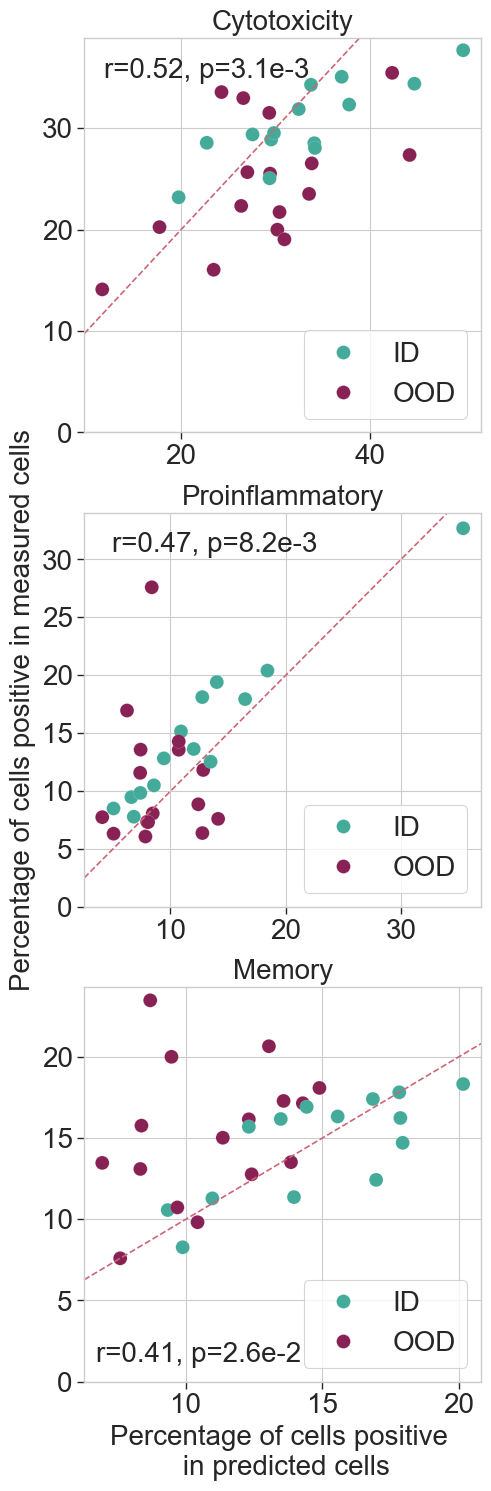

In [55]:
ID_OOD_map = {"ID": default_colors["teal"], "OOD": default_colors["wine"]}

scores=["Cytotoxicity", "Proinflammatory", "Memory"]
score_labels=["cytox_perc", "proinf_perc", "mem_perc"]

fig, axes = plt.subplots(3,1,sharex=False, sharey=False, figsize=(5,15))


for i, score in enumerate(scores):
    score_label = score_labels[i]
    spearman = round(spearmanr(plt_data[[f"{score_label}_transport", f"{score_label}_target"]]).statistic, 2)
    pval = Decimal(spearmanr(plt_data[[f"{score_label}_transport", f"{score_label}_target"]]).pvalue)
    pval = '{:.1e}'.format(pval)
    g = sns.scatterplot(data=plt_data, x=f"{score_label}_transport", y=f"{score_label}_target", hue="ID_OOD", 
                        palette=ID_OOD_map, ax=axes[i], s=100, linewidth=0.1)
    axes[i].legend(fontsize=20, title_fontsize=20, loc="lower right")
    axes[i].set_ylim((0,None))
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_title(score, fontsize=20)
    axes[i].axline(slope=1, xy1=(12,12), linestyle="--", color=default_colors["rose"])
    axes[i].tick_params(which="both", axis="both", labelsize=20)
    if i==0:
        axes[i].annotate(f"r={spearman}, p={pval}", xy=(0.05, 0.90), xycoords="axes fraction", fontsize=20)
    elif i==1:
        axes[i].annotate(f"r={spearman}, p={pval}", xy=(0.07, 0.90), xycoords="axes fraction", fontsize=20)
    elif i==2:
        axes[i].annotate(f"r={spearman}, p={pval}", xy=(0.03, 0.05), xycoords="axes fraction", fontsize=20)
fig.subplots_adjust(wspace=0.05)
axes[2].set_xlabel("Percentage of cells positive \n in predicted cells", fontsize=20)
axes[1].set_ylabel("Percentage of cells positive in measured cells", fontsize=20)
plt.tight_layout()
plt.savefig(f"{base_fig_save}percentage_pos_score_scatter_vertical.pdf", bbox_inches="tight")
plt.show()


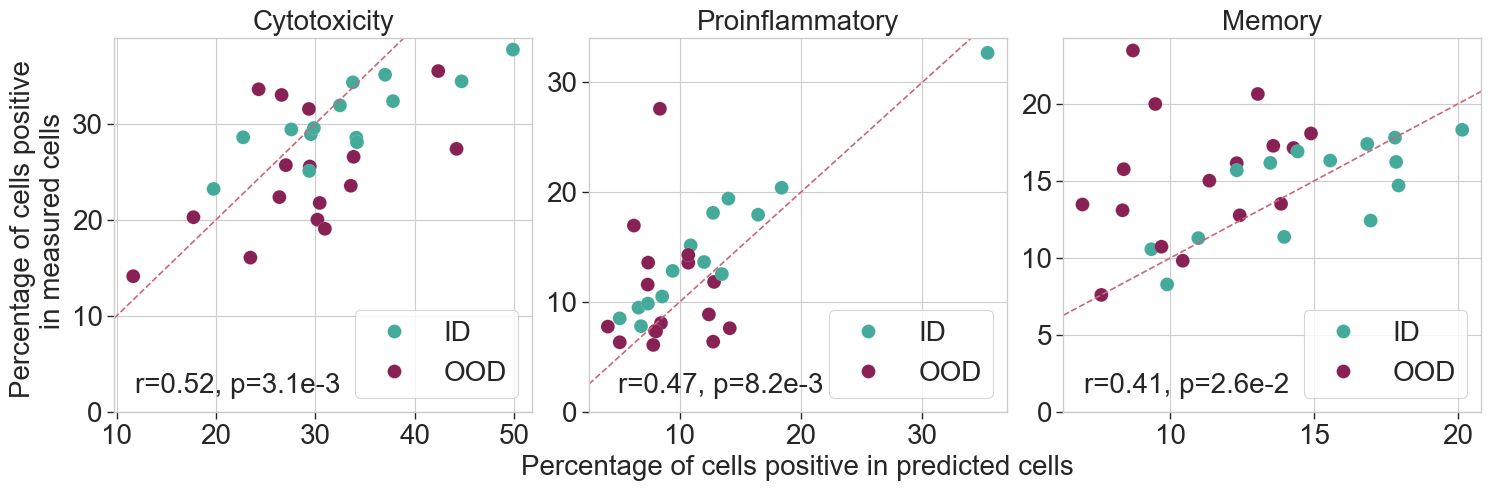

In [56]:
ID_OOD_map = {"ID": default_colors["teal"], "OOD": default_colors["wine"]}

scores=["Cytotoxicity", "Proinflammatory", "Memory"]
score_labels=["cytox_perc", "proinf_perc", "mem_perc"]

fig, axes = plt.subplots(1, 3,sharex=False, sharey=False, figsize=(15,5))


for i, score in enumerate(scores):
    score_label = score_labels[i]
    spearman = round(spearmanr(plt_data[[f"{score_label}_transport", f"{score_label}_target"]]).statistic, 2)
    pval = Decimal(spearmanr(plt_data[[f"{score_label}_transport", f"{score_label}_target"]]).pvalue)
    pval = '{:.1e}'.format(pval)
    g = sns.scatterplot(data=plt_data, x=f"{score_label}_transport", y=f"{score_label}_target", hue="ID_OOD", 
                        palette=ID_OOD_map, ax=axes[i], s=100, linewidth=0.1)
    axes[i].legend(fontsize=20, title_fontsize=20, loc="lower right")
    axes[i].set_ylim((0,None))
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_title(score, fontsize=20)
    axes[i].axline(slope=1, xy1=(12,12), linestyle="--", color=default_colors["rose"])
    axes[i].tick_params(which="both", axis="both", labelsize=20)
    if i==0:
        axes[i].annotate(f"r={spearman}, p={pval}", xy=(0.05, 0.05), xycoords="axes fraction", fontsize=20)
    elif i==1:
        axes[i].annotate(f"r={spearman}, p={pval}", xy=(0.07, 0.05), xycoords="axes fraction", fontsize=20)
    elif i==2:
        axes[i].annotate(f"r={spearman}, p={pval}", xy=(0.05, 0.05), xycoords="axes fraction", fontsize=20)
fig.subplots_adjust(wspace=0.05)
axes[1].set_xlabel("Percentage of cells positive in predicted cells", fontsize=20)
axes[0].set_ylabel("Percentage of cells positive \n in measured cells", fontsize=20)
plt.tight_layout()
plt.savefig(f"{base_fig_save}percentage_pos_score_scatter.pdf", bbox_inches="tight")
plt.show()


# Cell type distribution

In [57]:
with open("/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/celltype_models/20240229_from_rocio_for_manuscript_FuncScore_genes_svm.pkl", "rb") as f:
   celltyper = pickle.load(f)

/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.5.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [58]:
adata.obs["pred_celltype"] = celltyper.predict(adata.X)
adata.obs.loc[adata.obs['pred_celltype']=="CD4_Disfunctional", "pred_celltype"] = "CD4_Dysfunctional"
adata.obs.loc[adata.obs['pred_celltype']=="CD4_Early_Disfuncional", "pred_celltype"] = "CD4_Early_Dysfunctional"

In [59]:
plt_data1 = adata[(adata.obs["dtype"]=="transport")].obs.groupby(["CAR_Variant", "pred_celltype"]).size().reset_index().rename(columns={0:"count"})
plt_data1_tot = adata[(adata.obs["dtype"]=="transport")].obs.groupby(["CAR_Variant"]).size().reset_index().rename(columns={0:"total"})
plt_data1 = plt_data1.merge(plt_data1_tot, on="CAR_Variant", how="left")
plt_data1["celltype_frac"] = plt_data1["count"]/plt_data1["total"]
plt_data1 = plt_data1.pivot_table(index="CAR_Variant", columns="pred_celltype", values="celltype_frac")

plt_data2 = adata[(adata.obs["dtype"]=="target")].obs.groupby(["CAR_Variant", "pred_celltype"]).size().reset_index().rename(columns={0:"count"})
plt_data2_tot = adata[(adata.obs["dtype"]=="target")].obs.groupby(["CAR_Variant"]).size().reset_index().rename(columns={0:"total"})
plt_data2 = plt_data2.merge(plt_data2_tot, on="CAR_Variant", how="left")
plt_data2["celltype_frac"] = plt_data2["count"]/plt_data2["total"]
plt_data2 = plt_data2.pivot_table(index="CAR_Variant", columns="pred_celltype", values="celltype_frac")

anno = adata.obs[["subset", "CAR_Variant", "ID"]].drop_duplicates()
anno = anno.pivot_table(index="CAR_Variant", columns="subset", values="ID")
anno[["CD4", "CD8"]] = anno[["CD4", "CD8"]].astype(bool)
anno.columns = ["CD4", "CD8"]
anno=anno.loc[anno.index!="NA-NA-NA"]

# plt_data3 = adata[adata.obs["dtype"]=="source"].obs.groupby(["CAR_Variant", "pred_celltype"]).size().reset_index().rename(columns={0:"count"})
# plt_data3_tot = adata[adata.obs["dtype"]=="source"].obs.groupby(["CAR_Variant"]).size().reset_index().rename(columns={0:"total"})
# plt_data3 = plt_data3.merge(plt_data3_tot, on="CAR_Variant", how="left")
# plt_data3["celltype_frac"] = plt_data3["count"]/plt_data3["total"]
# plt_data3 = plt_data3.pivot_table(index="CAR_Variant", columns="pred_celltype", values="celltype_frac")

/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_74504/2382538360.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plt_data1 = adata[(adata.obs["dtype"]=="transport")].obs.groupby(["CAR_Variant", "pred_celltype"]).size().reset_index().rename(columns={0:"count"})
/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_74504/2382538360.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plt_data1_tot = adata[(adata.obs["dtype"]=="transport")].obs.groupby(["CAR_Variant"]).size().reset_index().rename(columns={0:"total"})
/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_74504/2382538360.p

In [60]:
myColors = (default_colors['wine'], default_colors['teal'])
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

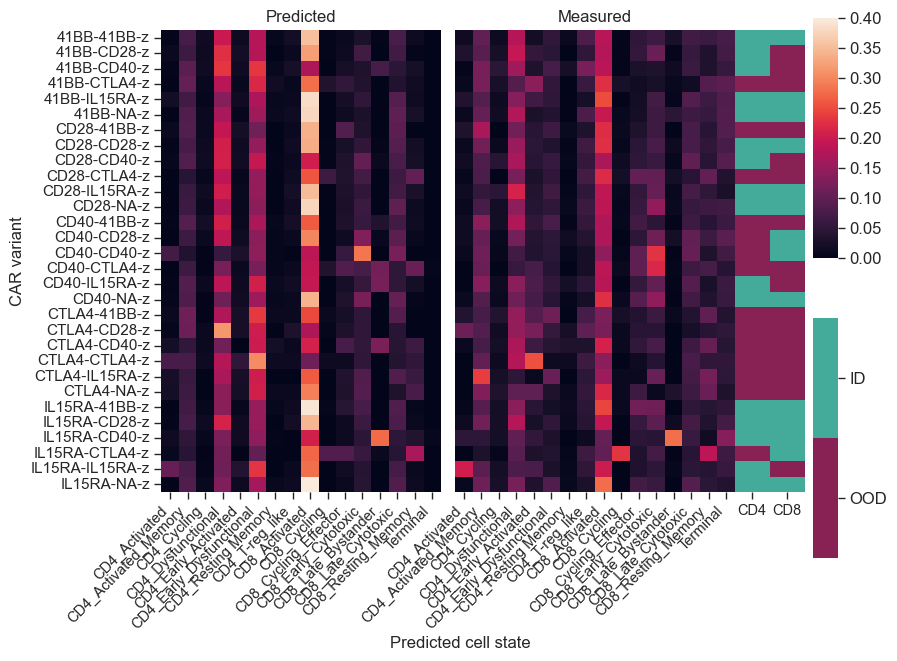

In [61]:
fig, axes = plt.subplots(1, 4, figsize=(8.3, 6), sharey="row", sharex="col", width_ratios=[4,0.2,4,1])
cbar_ax= fig.add_axes([0.91, 0.0, 0.03, 0.4])
cbar_ax2= fig.add_axes([0.91, 0.5, 0.03, 0.4])

sns.heatmap(data=plt_data1, ax=axes[0], vmin=0, vmax=0.4, cbar_ax=cbar_ax2)
sns.heatmap(data=plt_data2, ax=axes[2], vmin=0, vmax=0.4, cbar_ax=cbar_ax2)
sns.heatmap(data=anno, ax=axes[3], cbar_ax=cbar_ax, cmap=cmap)

axes[1].set_visible(False)

axes[0].set_title("Predicted", size=12)
axes[2].set_title("Measured", size=12)

axes[0].set_xlabel("")
axes[2].set_xlabel("")

axes[0].set_ylabel("CAR variant", size=12)
axes[2].set_ylabel("")
axes[3].set_ylabel("")

axes[0].set_yticks(axes[0].get_yticks(), axes[0].get_yticklabels(), size=11)
axes[0].set_xticks(axes[0].get_xticks(), axes[0].get_xticklabels(), rotation=45, ha="right", size=10.5)
axes[2].set_xticks(axes[2].get_xticks(), axes[2].get_xticklabels(), rotation=45, ha="right", size=10.5)
axes[3].set_xticks(axes[3].get_xticks(), axes[3].get_xticklabels(), size=10.5)
cbar_ax2.set_yticks(cbar_ax2.get_yticks(), cbar_ax2.get_yticklabels(), size=12)

axes[2].tick_params(which="both", axis="y",left=False)
axes[3].tick_params(which="both", axis="y",left=False)

cbar_ax.set_yticks([0.25, 0.75])
cbar_ax.set_yticklabels(["OOD", "ID"], size=12)

fig.text(0.4, -0.15, "Predicted cell state", size=12)
fig.subplots_adjust(wspace=0)
plt.savefig(f"{base_fig_save}celltype_comparison.pdf", bbox_inches="tight")


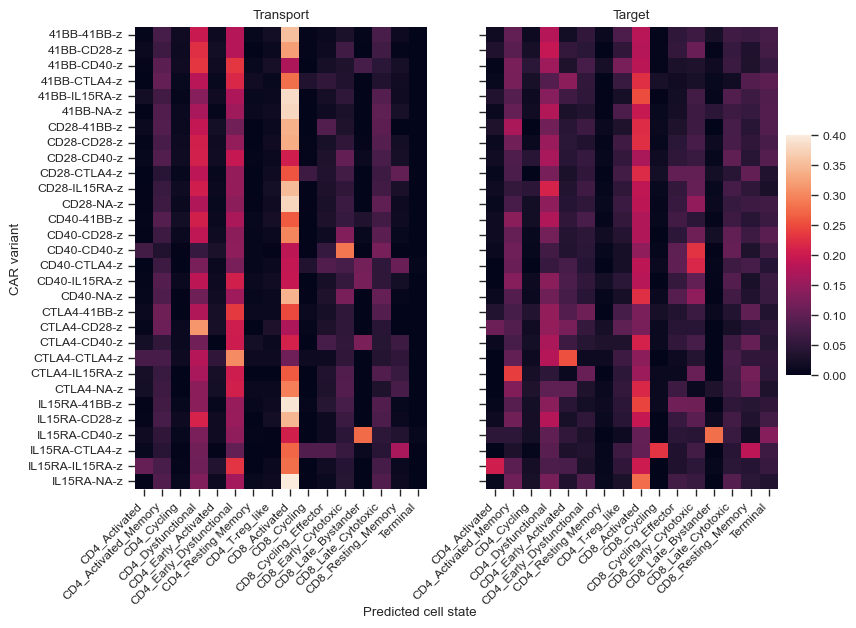

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(8.3, 6), sharey="row", sharex="col")
cbar_ax= fig.add_axes([0.91, 0.3, 0.03, 0.4])

sns.heatmap(data=plt_data1, ax=axes[0], vmin=0, vmax=0.4, cbar_ax=cbar_ax)
sns.heatmap(data=plt_data2, ax=axes[1], vmin=0, vmax=0.4, cbar_ax=cbar_ax)

axes[0].set_title("Transport")
axes[1].set_title("Target")

axes[0].set_xlabel("")
axes[1].set_xlabel("")

axes[0].set_ylabel("CAR variant")
axes[1].set_ylabel("")
fig.text(0.4, -0.1, "Predicted cell state")

axes[0].set_xticks(axes[0].get_xticks(), axes[0].get_xticklabels(), rotation=45, ha="right")
axes[1].set_xticks(axes[1].get_xticks(), axes[1].get_xticklabels(), rotation=45, ha="right")

# plt.savefig(f"{base_fig_save}celltype_comparison.pdf", bbox_inches="tight")


In [63]:
anno = adata.obs[["subset", "CAR_Variant", "ID"]].drop_duplicates()
anno = anno.pivot_table(index="CAR_Variant", columns="subset", values="ID")
anno[["CD4", "CD8"]] = anno[["CD4", "CD8"]].astype(bool)
anno.columns = ["CD4 - ID", "CD8 - ID"]
anno

/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_74504/3763293242.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  anno = anno.pivot_table(index="CAR_Variant", columns="subset", values="ID")


CD4 - ID  CD8 - ID
CAR_Variant                        
41BB-41BB-z          True      True
41BB-CD28-z          True     False
41BB-CD40-z          True     False
41BB-CTLA4-z        False     False
41BB-IL15RA-z        True      True
41BB-NA-z            True      True
CD28-41BB-z         False     False
CD28-CD28-z          True      True
CD28-CD40-z          True     False
CD28-CTLA4-z        False     False
CD28-IL15RA-z        True      True
CD28-NA-z            True      True
CD40-41BB-z         False     False
CD40-CD28-z         False      True
CD40-CD40-z         False      True
CD40-CTLA4-z        False     False
CD40-IL15RA-z        True     False
CD40-NA-z            True      True
CTLA4-41BB-z        False     False
CTLA4-CD28-z        False     False
CTLA4-CD40-z        False     False
CTLA4-CTLA4-z       False     False
CTLA4-IL15RA-z      False     False
CTLA4-NA-z          False     False
IL15RA-41BB-z        True      True
IL15RA-CD28-z        True      True
IL15RA-CD40-z        True      True
IL15RA-CTLA4-z      False      True
IL15RA-IL15RA-z      True     False
IL15RA-NA-z          True      True
NA-NA-NA            False     False

In [64]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [65]:
temp = cosine_similarity(plt_data1.T, plt_data2.T)

In [66]:
temp.shape

(16, 16)

In [67]:
pd.DataFrame(temp, index=pd.Series(plt_data1.columns, name="Target"), columns=pd.Series(plt_data2.columns, name="Transport"))

Transport                CD4_Activated  CD4_Activated_Memory  CD4_Cycling  \
Target                                                                      
CD4_Activated                 0.670519              0.505853     0.416287   
CD4_Activated_Memory          0.530710              0.927043     0.867516   
CD4_Cycling                   0.391295              0.791695     0.782940   
CD4_Dysfunctional             0.496104              0.914654     0.854349   
CD4_Early_Activated           0.610546              0.847390     0.740432   
CD4_Early_Dysfunctional       0.529926              0.927759     0.878899   
CD4_Resting Memory            0.192302              0.677333     0.679844   
CD4_T-reg_like                0.497236              0.825168     0.814177   
CD8_Activated                 0.462711              0.904086     0.812513   
CD8_Cycling                   0.081451              0.303092     0.196925   
CD8_Cycling_Effector          0.329970              0.791918     0.602260   
CD8_Early_Cytotoxic           0.330305              0.780717     0.633473   
CD8_Late_Bystander            0.176387              0.320411     0.330132   
CD8_Late_Cytotoxic            0.471712              0.907971     0.772335   
CD8_Resting_Memory            0.129134              0.552792     0.435719   
Terminal                      0.146269              0.177652     0.143805   

Transport                CD4_Dysfunctional  CD4_Early_Activated  \
Target                                                            
CD4_Activated                     0.434091             0.624460   
CD4_Activated_Memory              0.945920             0.824037   
CD4_Cycling                       0.938048             0.667942   
CD4_Dysfunctional                 0.964601             0.781725   
CD4_Early_Activated               0.805787             0.866071   
CD4_Early_Dysfunctional           0.942255             0.871755   
CD4_Resting Memory                0.714184             0.757689   
CD4_T-reg_like                    0.938577             0.730547   
CD8_Activated                     0.933389             0.690151   
CD8_Cycling                       0.340234             0.372291   
CD8_Cycling_Effector              0.730182             0.648761   
CD8_Early_Cytotoxic               0.722824             0.609476   
CD8_Late_Bystander                0.348134             0.311932   
CD8_Late_Cytotoxic                0.907416             0.664664   
CD8_Resting_Memory                0.536185             0.508733   
Terminal                          0.182229             0.218733   

Transport                CD4_Early_Dysfunctional  CD4_Resting Memory  \
Target                                                                 
CD4_Activated                           0.386925            0.397872   
CD4_Activated_Memory                    0.927469            0.722871   
CD4_Cycling                             0.780143            0.738719   
CD4_Dysfunctional                       0.912366            0.735748   
CD4_Early_Activated                     0.776957            0.610538   
CD4_Early_Dysfunctional                 0.903494            0.743572   
CD4_Resting Memory                      0.657562            0.667316   
CD4_T-reg_like                          0.840757            0.781161   
CD8_Activated                           0.892813            0.637135   
CD8_Cycling                             0.359893            0.139255   
CD8_Cycling_Effector                    0.761040            0.629314   
CD8_Early_Cytotoxic                     0.734719            0.576562   
CD8_Late_Bystander                      0.315426            0.384224   
CD8_Late_Cytotoxic                      0.899072            0.622349   
CD8_Resting_Memory                      0.532396            0.402109   
Terminal                                0.186566            0.032754   

Transport                CD4_T-reg_like  CD8_Activated  CD8_Cycling  \
Target                                

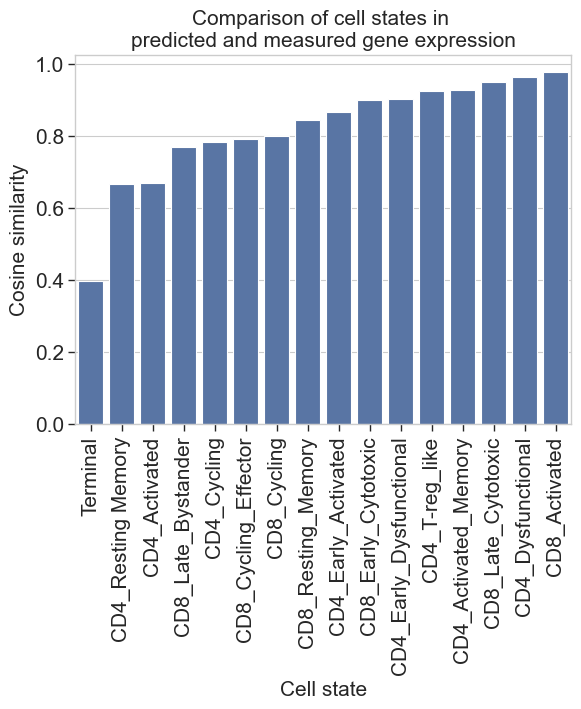

In [68]:
sns.barplot(pd.Series(np.diagonal(temp), index=plt_data1.columns).sort_values())
t = plt.xticks(rotation=90, fontsize=15)
t = plt.yticks(fontsize=15)
t = plt.xlabel("Cell state", fontsize=15)
t = plt.ylabel("Cosine similarity", fontsize=15)
t = plt.title("Comparison of cell states in \npredicted and measured gene expression", fontsize=15)
plt.savefig(f"{base_fig_save}cellstate_prediction_quality.pdf", bbox_inches="tight")


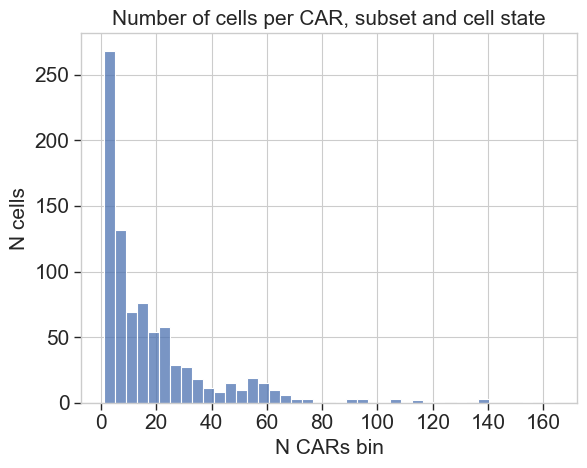

In [69]:
t = adata.obs.groupby(["CAR_Variant", "dtype", "pred_celltype"], observed=True).size().sort_values().reset_index()
t = t[t["CAR_Variant"]!="NA-NA-NA"]
sns.histplot(t[0])
p = plt.xticks(fontsize=15)
p = plt.yticks(fontsize=15)
p = plt.xlabel("N CARs bin", fontsize=15)
p = plt.ylabel("N cells", fontsize=15)
p = plt.title("Number of cells per CAR, subset and cell state", fontsize=15)
plt.savefig(f"{base_fig_save}cellstate_subset_car_count.pdf", bbox_inches="tight")
